In [1]:
# ============================================================
# IMPORTAÇÃO DAS BIBLIOTECAS
# ============================================================
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthBegin
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from scipy.interpolate import make_interp_spline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #modelo de analise de sentimentos
from langdetect import detect # detecta o idioma da coluna, no caso, vamos usar para detectar o idioma do nome da musica
from deep_translator import GoogleTranslator # apos descobrir o idioma, traduz para o ingles
from scipy.ndimage import gaussian_filter1d
import numpy as np
import warnings
import os
from sqlalchemy import create_engine
from datetime import datetime
from dotenv import load_dotenv
 
warnings.filterwarnings('ignore')

# ============================================================
## ETL
# ============================================================
### --- Load and Combine JSON Files --- ###
# Define the root folder
root_folder = r'C:\Users\tomas\OneDrive\Documentos\project_python_pipeline_tomas_spotify\treated_database'

combined_data = []

# Percorre todas as subpastas dentro de treated_database
for pessoa in os.listdir(root_folder):
    pessoa_path = os.path.join(root_folder, pessoa)

    # Garante que é uma pasta (evita erro caso haja arquivos soltos)
    if os.path.isdir(pessoa_path):
        json_files = [file for file in os.listdir(pessoa_path) if file.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(pessoa_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

                # Adiciona colunas extras
                for record in data:
                    record['source_file'] = file_name  # Nome do arquivo
                    record['pessoa'] = pessoa          # Nome da pasta (ex.: tomas, joao, maria)

                combined_data.extend(data)

# Convert to DataFrame
df_combined = pd.DataFrame(combined_data)

### --- ETL: Transformations --- ###
# Convert 'ts' to datetime
df_combined['ts'] = pd.to_datetime(df_combined['ts'])

# Extract date, time, year and month
df_combined['year'] = df_combined['ts'].dt.year
df_combined['month'] = df_combined['ts'].dt.month
df_combined['date'] = df_combined['ts'].dt.date
df_combined['time'] = df_combined['ts'].dt.hour
df_combined['year_month'] = df_combined['ts'].dt.strftime('%Y-%m')

# Extract weekday
df_combined['weekday'] = df_combined['ts'].dt.day_name()

# Categorize platform
def categorize_platform(platform):
    platform = platform.lower()
    if any(keyword in platform for keyword in ['android', 'iphone', 'ios']):
        return 'Phone'
    elif any(keyword in platform for keyword in ['web_player', 'chrome', 'microsoft edge']):
        return 'Computer - online'
    elif  any(keyword in platform for keyword in ['tv', 'echo-dot', 'partner']):
        return 'TV'
    elif any(keyword in platform for keyword in ['windows', 'osx', 'os x']):
        return 'Computer - desktop'
    else:
        return 'Others'

df_combined['platform_category'] = df_combined['platform'].apply(categorize_platform)

# Convert playtime from milliseconds to seconds and minutes
df_combined['seconds_played'] = df_combined['ms_played'] / 1000
df_combined['minutes_played'] = df_combined['ms_played'] / (1000 * 60)


# Criar coluna de tipo de conteúdo
def classificar_conteudo(row):
    if pd.notnull(row['audiobook_title']):
        return 'Audiobook'
    elif pd.notnull(row['episode_name']):
        return 'Podcast'
    else:
        return 'Música'

df_combined['tipo_conteudo'] = df_combined.apply(classificar_conteudo, axis=1)

# Drop unnecessary column
df_combined.drop(columns=[
    'ip_addr',
    'conn_country',
    'episode_name',
    'episode_show_name',
    'spotify_episode_uri',
    'audiobook_title',
    'audiobook_uri',
    'audiobook_chapter_uri',
    'audiobook_chapter_title',
    'incognito_mode',
    'offline_timestamp'
], inplace=True)

### Final Output ###
df_combined
# Filtra com query
# Remove o timezone
df_combined["ts"] = df_combined["ts"].dt.tz_localize(None)
# --- Mínimo e máximo de ts por pessoa ---
min_max_por_pessoa = df_combined.groupby("pessoa")["ts"].agg(
    min_value_ts="min",
    max_value_ts="max"
).reset_index()

# --- Define intervalo comum para todos ---
# Maior mínimo entre as pessoas
data_inicio_raw = min_max_por_pessoa["min_value_ts"].max()
# Ajusta para o dia 01 do mês seguinte
data_inicio = (data_inicio_raw + MonthBegin(1)).normalize()

# Menor máximo entre as pessoas
data_fim = min_max_por_pessoa["max_value_ts"].min().normalize()

# --- Filtra o DataFrame pelo intervalo comum ---
df_combined = df_combined.query("ts >= @data_inicio and ts <= @data_fim")


In [2]:
## Define a pool de artistas para rodar a API do Spotify - buscar generos e popularidade
df_artistas = pd.DataFrame({
    "artist_name": df_combined['master_metadata_album_artist_name'].dropna().unique()
})
df_artistas

artist_name
0               MC WM
1        Manu Gavassi
2            Mad Dogz
3               POCAH
4          WC no Beat
...               ...
13178          Graves
13179      Hitchhiker
13180         LEISURE
13181  Arte No Escuro
13182          Sun Lo

[13183 rows x 1 columns]

In [3]:
# ============================================================
# SPOTIFY API -- GET ARTISTS GENRES AND POPULARITY
# ------------------------------------------------------------
# OBS: A API foi comentada para não rodar toda vez, 
# pois ela demora bastante e já gerou todos os dados necessários.
# No meu caso, a execução durou 66min44s para processar 11.103 registros (artistas diferentes).
# Em vez de rodar a API, vamos carregar o resultado já salvo em Excel.
# ============================================================
""" 
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pandas as pd
import time
from spotipy.exceptions import SpotifyException
from tqdm import tqdm   # barra de progresso
from dotenv import load_dotenv
import os

# --- Configurar autenticação ---
load_dotenv()

client_id  = os.getenv("spotify_client_id")
client_secret = os.getenv("spotify_client_secret")
print(client_id)
print(client_secret)

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# --- Função para buscar ID do artista pelo nome ---
def get_artist_id(artist_name):
    try:
        result = sp.search(q=f"artist:{artist_name}", type='artist', limit=1)
        items = result['artists']['items']
        if items:
            return items[0]['id']
        return None
    except Exception as e:
        print(f"Erro ao buscar ID de {artist_name}: {e}")
        return None

# --- Adicionar coluna com IDs ---
df_artistas['spotify_id'] = df_artistas['artist_name'].apply(get_artist_id)

# --- Preparar colunas de retorno ---
df_artistas['genres'] = None
df_artistas['popularity'] = None

# --- Processar em lotes de 50 ---
batch_size = 50
artist_ids = df_artistas['spotify_id'].dropna().tolist()

for i in tqdm(range(0, len(artist_ids), batch_size)):
    batch_ids = artist_ids[i:i+batch_size]
    success = False

    while not success:  # tenta até conseguir
        try:
            artists_info = sp.artists(batch_ids)['artists']
            for artist in artists_info:
                df_artistas.loc[df_artistas['spotify_id'] == artist['id'], 'genres'] = str(artist['genres'])  # ✅ corrigido
                df_artistas.loc[df_artistas['spotify_id'] == artist['id'], 'popularity'] = artist['popularity']
            success = True
            time.sleep(0.2)  # pausa pequena entre lotes normais

        except SpotifyException as e:
            if e.http_status == 429:  # limite atingido
                retry_after = int(e.headers.get("Retry-After", 5))
                print(f"Rate limit atingido. Aguardando {retry_after} segundos...")
                time.sleep(retry_after + 1)  # espera +1 pra garantir
            else:
                print(f"Erro inesperado no lote {i}-{i+batch_size}: {e}")
                success = True  # pula esse lote se der outro erro

# Exportar para Excel
df_artistas.to_excel("df_artistas.xlsx", index=False) 
print("Arquivo salvo como df_artistas.xlsx") """


' \nfrom spotipy.oauth2 import SpotifyClientCredentials\nimport spotipy\nimport pandas as pd\nimport time\nfrom spotipy.exceptions import SpotifyException\nfrom tqdm import tqdm   # barra de progresso\nfrom dotenv import load_dotenv\nimport os\n\n# --- Configurar autenticação ---\nload_dotenv()\n\nclient_id  = os.getenv("spotify_client_id")\nclient_secret = os.getenv("spotify_client_secret")\nprint(client_id)\nprint(client_secret)\n\nauth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)\nsp = spotipy.Spotify(auth_manager=auth_manager)\n\n# --- Função para buscar ID do artista pelo nome ---\ndef get_artist_id(artist_name):\n    try:\n        result = sp.search(q=f"artist:{artist_name}", type=\'artist\', limit=1)\n        items = result[\'artists\'][\'items\']\n        if items:\n            return items[0][\'id\']\n        return None\n    except Exception as e:\n        print(f"Erro ao buscar ID de {artist_name}: {e}")\n        return None\n\n# --- A

In [4]:
# ============================================================
# SPOTIFY API -- GET ARTISTS GENRES AND POPULARITY - UPLOADED EXCEL
# ============================================================
# OBS: API comentada para não rodar toda vez; carrega resultado salvo no Excel

# Caminho do arquivo Excel gerado anteriormente
arquivo_excel = r"C:\Users\tomas\OneDrive\Documentos\project_python_pipeline_tomas_spotify\df_artistas.xlsx"

# Ler o Excel
df_artistas = pd.read_excel(arquivo_excel)

# Converter a coluna 'genres' de string tipo "['rock','pop']" para "rock,pop"
def clean_genres(genres_str):
    if pd.isna(genres_str):
        return ""
    # Remove colchetes e aspas simples, depois remove espaços extras
    cleaned = genres_str.strip("[]").replace("'", "").replace('"', '').strip()
    return cleaned

df_artistas['genres'] = df_artistas['genres'].apply(clean_genres)

# Conferir resultado
df_artistas


artist_name              spotify_id  \
0               MC WM  14D0I0RYqvIorkPL2EWoQh   
1        Manu Gavassi  6xF3XdxG7VHRmQmTJxRqX8   
2            Mad Dogz  18RtsuKFWko5JfeMsIi0YP   
3               POCAH  11iQCRz636WFdHj42qxAF6   
4          WC no Beat  2QjS2N6sORI7H4qbf6xitS   
...               ...                     ...   
11100      Hitchhiker  5ePDPFrSdmaieYrKrPDJPx   
11101        Borgeous  4uiMn2g0pgTrhN096QJhbp   
11102         LEISURE  7b04D0yLktCUpvxQBhmG7R   
11103  Arte No Escuro  3pnpiqMUWZ5RaYY9YtkGi5   
11104          Sun Lo  4bLLB1dbsRVUTcMpnDGDO2   

                                                  genres  popularity  
0                             brazilian funk, brega funk        60.0  
1                                          brazilian pop        50.0  
2      piseiro, funk pop, arrocha, forró, brazilian f...        36.0  
3      brazilian funk, funk pop, brazilian pop, funk ...        54.0  
4      brazilian hip hop, brazilian funk, trap funk, ...        55.0  
...                                                  ...         ...  
11100                                        noise music        24.0  
11101                                      big room, edm        55.0  
11102                                         indie soul        69.0  
11103        post-punk, deathrock, darkwave, gothic rock        20.0  
11104          opm, harana, pinoy indie, p-pop, kundiman        62.0  

[11105 rows x 4 columns]

In [5]:
# Fazendo o merge entre df_combined e a nova info dos artistas
df_combined = df_combined.merge(
    df_artistas[['artist_name', 'genres', 'popularity']],  # só as colunas relevantes
    how='left',  # left = mantém todos os registros do df original
    left_on='master_metadata_album_artist_name',  # chave no df original
    right_on='artist_name' )

In [6]:
# ============================================================
#INGESTÃO DOS DADOS NO BANCO POSTGRES: 
# Schema spotify precisa existir
## O to_sql não cria schema, apenas tabelas.
### Certifique-se de criar o schema antes no banco:
####  CREATE SCHEMA IF NOT EXISTS spotify

# Configuração de conexão
# Carregar variáveis do .env
load_dotenv()

usuario = os.getenv("db_user")
senha = os.getenv("db_pass")
host = os.getenv("db_host")
porta = os.getenv("db_port")
banco = os.getenv("db_name")

# Cria engine de conexão
engine = create_engine(f"postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}")

# --- Função para ingestão ---
def salvar_df_no_postgres(df, nome_tabela, schema="spotify", if_exists="replace", add_data_carga=True):
    """
    Salva um DataFrame no PostgreSQL.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame a ser salvo
    nome_tabela (str): Nome da tabela no banco
    schema (str): Schema de destino
    if_exists (str): Comportamento se a tabela existir ['fail', 'replace', 'append']
    add_data_carga (bool): Se True, adiciona coluna com timestamp da carga
    """
    df_to_save = df.copy()

    if add_data_carga:
        df_to_save["data_carga_dados"] = datetime.now()

    df_to_save.to_sql(
        name=nome_tabela,
        con=engine,
        schema=schema,
        if_exists=if_exists,
        index=False
    )
    print(f"Dados salvos em {schema}.{nome_tabela} ({len(df)} linhas).")

# --- Uso ---
# Salvar df_combined
salvar_df_no_postgres(df_combined, "hist_streaming")
# Salvar df_artistas
salvar_df_no_postgres(df_artistas, "artistas")


Dados salvos em spotify.hist_streaming (390898 linhas).
Dados salvos em spotify.artistas (11105 linhas).


In [7]:
# DEFINIÇÃO DO INTERVALO DE DATAS ENTRE OS USUÁRIOS - PADRONIZAÇÃO
print(f"Intervalo usado para todos: {data_inicio} até {data_fim}")

Intervalo usado para todos: 2020-10-01 00:00:00 até 2025-08-23 00:00:00


In [8]:
# ============================================================
## METADATA
# ============================================================
metadata_table = pd.DataFrame({
    'Nome da Coluna': df_combined.columns,
    'Tipo de Dado': [df_combined[col].dtype for col in df_combined.columns],
    'Valores Únicos': [df_combined[col].nunique() for col in df_combined.columns],
    'Valores Nulos': [df_combined[col].isnull().sum() for col in df_combined.columns]
})

# Exibir a tabela
metadata_table


Nome da Coluna    Tipo de Dado  Valores Únicos  \
0                                  ts  datetime64[ns]          366372   
1                            platform          object              94   
2                           ms_played           int64          128714   
3          master_metadata_track_name          object           36811   
4   master_metadata_album_artist_name          object           13183   
5    master_metadata_album_album_name          object           26164   
6                   spotify_track_uri          object           43670   
7                        reason_start          object              11   
8                          reason_end          object              11   
9                             shuffle            bool               2   
10                            skipped            bool               2   
11                            offline          object               2   
12                        source_file          object              29   
13                             pessoa          object               5   
14                               year           int32               6   
15                              month           int32              12   
16                               date          object            1787   
17                               time           int32              24   
18                         year_month          object              59   
19                            weekday          object               7   
20                  platform_category          object               5   
21                     seconds_played         float64          128714   
22                     minutes_played         float64          128714   
23                      tipo_conteudo          object               2   
24                        artist_name          object           11104   
25                             genres          object            3127   
26                         popularity         float64             100   

    Valores Nulos  
0               0  
1               0  
2               0  
3             905  
4             905  
5             905  
6             905  
7               0  
8               0  
9               0  
10              0  
11            139  
12              0  
13              0  
14              0  
15              0  
16              0  
17              0  
18              0  
19              0  
20              0  
21              0  
22              0  
23              0  
24          23525  
25          22620  
26          23041

In [9]:
# TESTES DE DADOS ÚNICOS NA COLUNA E DATAS MIN X MAX ENTRE USUARIOS
## teste unique
df_combined['platform'].unique()
df_combined['reason_start'].unique()

df_combined['reason_end'].unique()
df_combined['tipo_conteudo'].unique()

min_value_ts = df_combined['ts'].min()
max_value_ts = df_combined['ts'].max()
min_value_ts
max_value_ts

# Mínimo e máximo de ts por pessoa
min_max_por_pessoa = (
    df_combined.groupby("pessoa")["ts"]
    .agg(min_value_ts="min", max_value_ts="max")
    .reset_index()
)

# min_max_por_pessoa


In [10]:
# ============================================================
## Filtro da base para uma pessoa específica
# ============================================================
filtro_pessoa = 'tomas'
df_combined = df_combined.query("pessoa == @filtro_pessoa") 


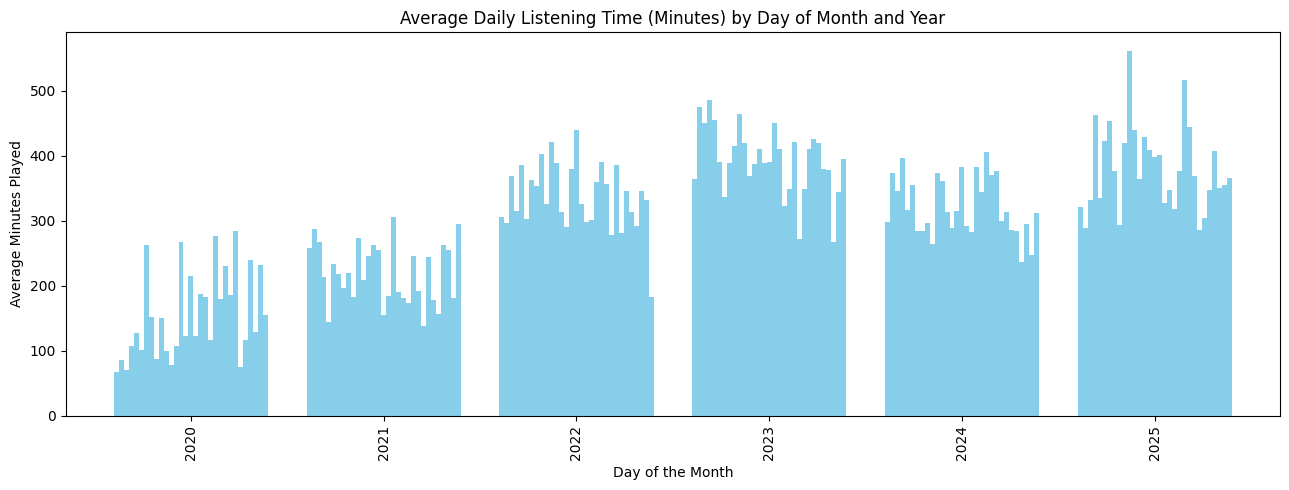

In [11]:
# Análise 1 — Média de Minutos Escutados por Dia

# Extrair ano, mês e dia
df_combined['year'] = df_combined['ts'].dt.year
df_combined['month'] = df_combined['ts'].dt.month
df_combined['day'] = df_combined['ts'].dt.day

# Somar minutos por dia
daily_totals = df_combined.groupby(['year', 'month', 'day'])['minutes_played'].sum().reset_index()

# Média dos totais diários por ano e dia
avg_minutes_by_day_year = daily_totals.groupby(['year', 'day'])['minutes_played'].mean().unstack()

# Plotar todas as barras na cor azul e sem legenda
fig, ax = plt.subplots(figsize=(13, 5))
avg_minutes_by_day_year.plot(kind='bar', ax=ax, width=0.8, color='skyblue')

# Formatação
ax.set_title('Average Daily Listening Time (Minutes) by Day of Month and Year')
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Average Minutes Played')
ax.legend_.remove()  # Remove legenda
plt.tight_layout()
plt.show()


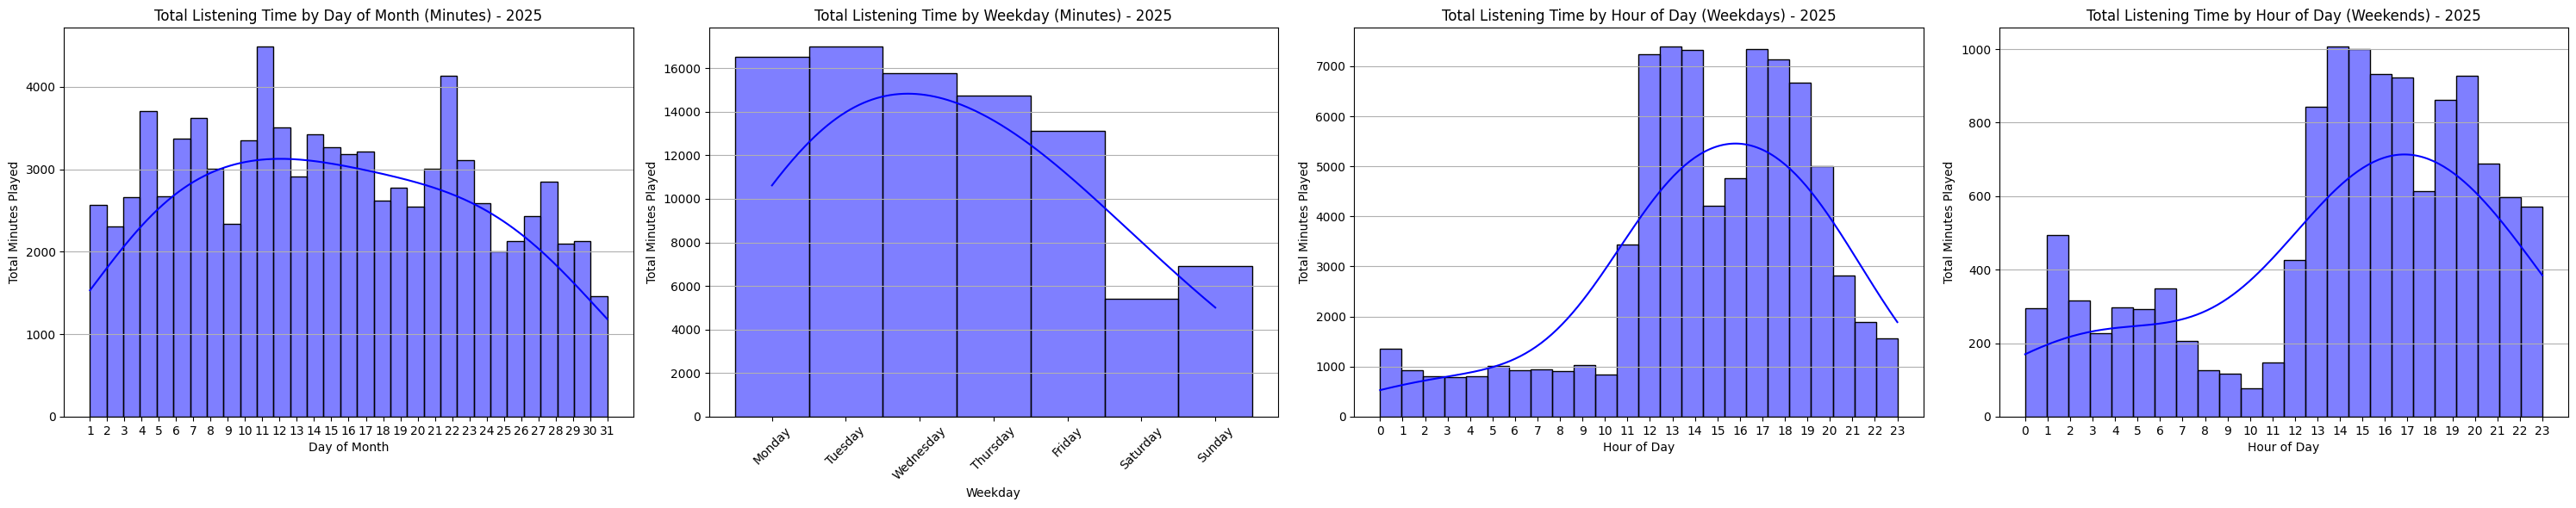

In [12]:
#Análise 2 — Padrões de Escuta em 2025 (Histogramas por dia do mês, dia da semana, hora do dia (aberto em finais de semana e dias de semana))

# Filtrar apenas o ano de 2025
df_2025 = df_combined[df_combined['ts'].dt.year == 2025]
df_2025['time'] = pd.to_numeric(df_2025['time'], errors='coerce')

# Agrupar por dia do mês
df_2025['day'] = df_2025['ts'].dt.day
daily_sum_2025 = df_2025.groupby('day')['minutes_played'].sum().reset_index()

# Agrupar por dia da semana (usando coluna existente)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sum_2025 = df_2025.groupby('weekday')['minutes_played'].sum().reindex(weekday_order).reset_index()

# Agrupar por hora do dia 
hour_sum_2025 = df_2025.groupby('time')['minutes_played'].sum().reset_index()
hour_sum_2025_semana = df_2025.query("weekday != 'Saturday' and weekday != 'Sunday'").groupby('time')['minutes_played'].sum().reset_index()
hour_sum_2025_fds = df_2025.query("weekday == 'Saturday' or weekday == 'Sunday'").groupby('time')['minutes_played'].sum().reset_index()

fig, axs = plt.subplots(1, 4, figsize=(30, 6))

# Gráfico por dia do mês
sns.histplot(x=daily_sum_2025['day'], weights=daily_sum_2025['minutes_played'],
             bins=len(daily_sum_2025['day']), kde=True,  color='blue', ax=axs[0])
axs[0].set_title('Total Listening Time by Day of Month (Minutes) - 2025')
axs[0].set_xlabel('Day of Month')
axs[0].set_ylabel('Total Minutes Played')
axs[0].set_xticks(daily_sum_2025['day'])
axs[0].grid(axis='y')

# Gráfico por dia da semana
sns.histplot(x=weekday_sum_2025['weekday'], weights=weekday_sum_2025['minutes_played'],
             bins=len(weekday_order), kde=True, color='blue', ax=axs[1])
axs[1].set_title('Total Listening Time by Weekday (Minutes) - 2025')
axs[1].set_xlabel('Weekday')
axs[1].set_ylabel('Total Minutes Played')
axs[1].set_xticks(range(len(weekday_order)))
axs[1].set_xticklabels(weekday_order, rotation=45)
axs[1].grid(axis='y')

# Gráfico por hora do dia -- dias de semana
sns.histplot(x=hour_sum_2025_semana['time'], weights=hour_sum_2025_semana['minutes_played'],
             bins=len(hour_sum_2025_semana['time']), kde=True, color='blue', ax=axs[2])
axs[2].set_title('Total Listening Time by Hour of Day (Weekdays) - 2025')
axs[2].set_xlabel('Hour of Day')
axs[2].set_ylabel('Total Minutes Played')
axs[2].set_xticks(hour_sum_2025_semana['time'])
axs[2].grid(axis='y')

# Gráfico por hora do dia -- dias de final de semana
# pegando apenas final de semana
sns.histplot(x=hour_sum_2025_fds['time'], weights=hour_sum_2025_fds['minutes_played'],
             bins=len(hour_sum_2025_fds['time']), kde=True, color='blue', ax=axs[3])
axs[3].set_title('Total Listening Time by Hour of Day (Weekends) - 2025')
axs[3].set_xlabel('Hour of Day')
axs[3].set_ylabel('Total Minutes Played')
axs[3].set_xticks(hour_sum_2025_fds['time'])
axs[3].grid(axis='y')

plt.tight_layout()
plt.show()


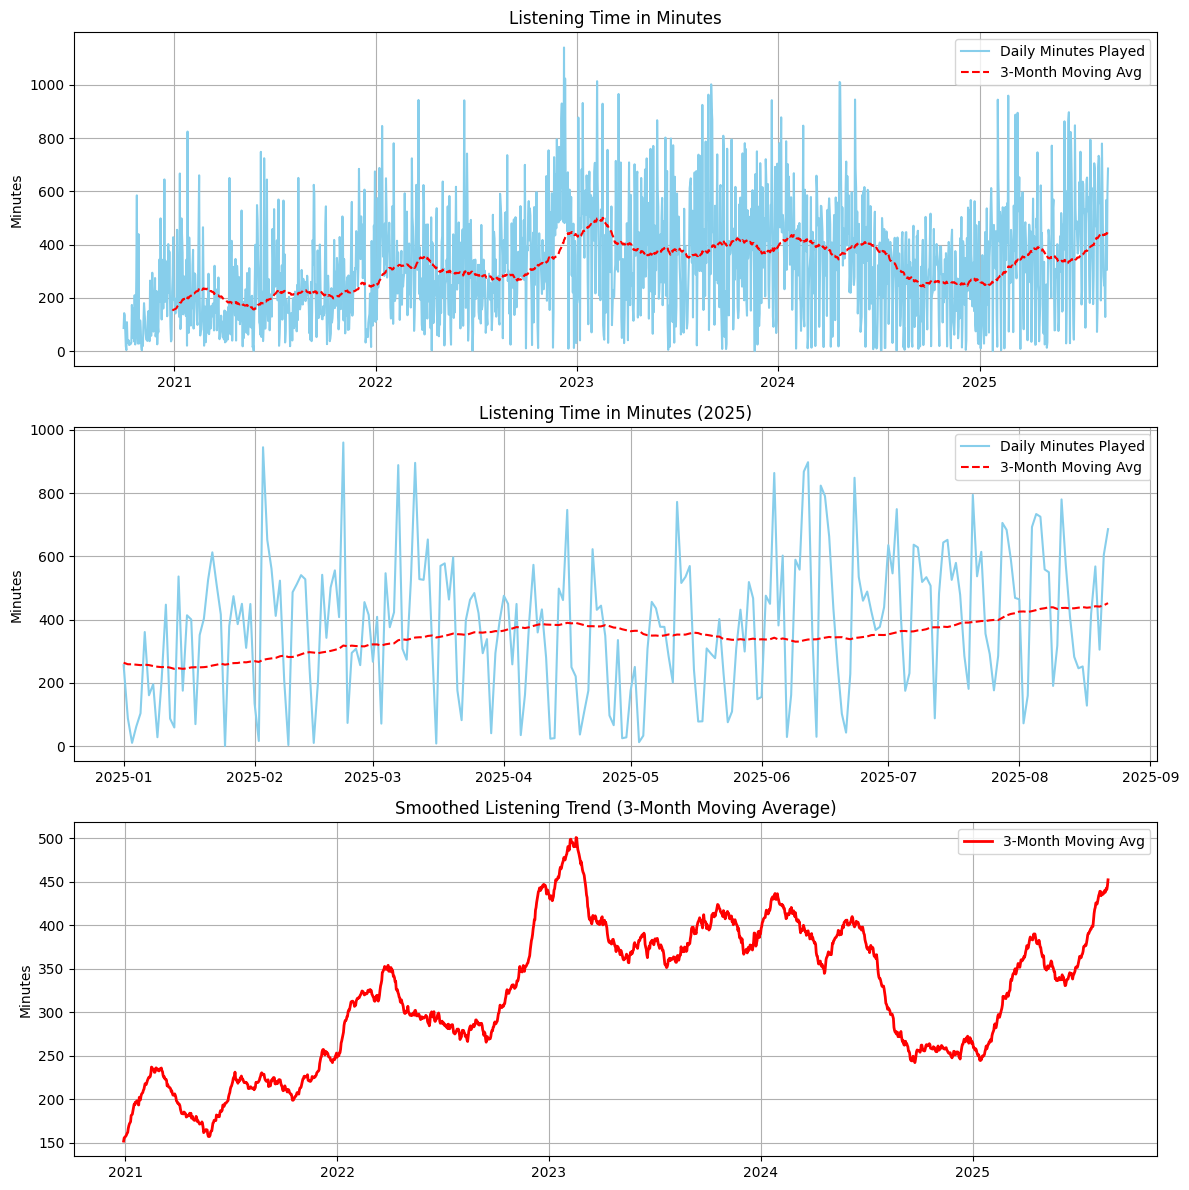

In [13]:
#Análise 3 — Tendência de Escuta ao Longo do Tempo (Série temporal por minuto/hora/dia)

# Flags para habilitar os gráficos principais
show_minutes = True
show_hours = False
show_days = False

# Aggregate total minutes played per day
daily_minutes = df_combined.groupby(df_combined['ts'].dt.date)['minutes_played'].sum().reset_index()
daily_minutes['ts'] = pd.to_datetime(daily_minutes['ts'])

# Calculate 3-month moving average (approx. 90 days)
daily_minutes['moving_avg_3_months'] = daily_minutes['minutes_played'].rolling(window=90).mean()

# Convert minutes to hours and days
daily_minutes['hours_played'] = daily_minutes['minutes_played'] / 60
daily_minutes['moving_avg_3_months_hours'] = daily_minutes['hours_played'].rolling(window=90).mean()

daily_minutes['days_played'] = daily_minutes['hours_played'] / 24
daily_minutes['moving_avg_3_months_days'] = daily_minutes['days_played'].rolling(window=90).mean()

# Filtrar apenas o ano de 2024 e 2025
daily_minutes_2024 = daily_minutes[daily_minutes['ts'].dt.year == 2024]
daily_minutes_2025 = daily_minutes[daily_minutes['ts'].dt.year == 2025]

# Contar quantos gráficos principais serão exibidos
num_main_plots = sum([show_minutes, show_hours, show_days])
num_total_plots = num_main_plots + 2  # adiciona os dois gráficos extras

# Criar subplots dinamicamente
fig, axs = plt.subplots(num_total_plots, 1, figsize=(12, 4 * num_total_plots), sharex=False)

# Se houver apenas um gráfico, axs não é uma lista
if num_total_plots == 1:
    axs = [axs]

plot_index = 0

# Gráfico de minutos
if show_minutes:
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['minutes_played'], color='skyblue', label='Daily Minutes Played')
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['moving_avg_3_months'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Minutes')
    axs[plot_index].set_ylabel('Minutes')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# Gráfico de horas
if show_hours:
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['hours_played'], color='green', label='Daily Hours Played')
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['moving_avg_3_months_hours'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Hours')
    axs[plot_index].set_ylabel('Hours')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# Gráfico de dias
if show_days:
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['days_played'], color='purple', label='Daily Days Played')
    axs[plot_index].plot(daily_minutes['ts'], daily_minutes['moving_avg_3_months_days'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Days')
    axs[plot_index].set_ylabel('Days')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# Gráfico filtrado apenas para 2025
if show_minutes:
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['minutes_played'], color='skyblue', label='Daily Minutes Played')
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['moving_avg_3_months'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Minutes (2025)')
    axs[plot_index].set_ylabel('Minutes')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
elif show_hours:
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['hours_played'], color='green', label='Daily Hours Played')
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['moving_avg_3_months_hours'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Hours (2025)')
    axs[plot_index].set_ylabel('Hours')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
elif show_days:
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['days_played'], color='purple', label='Daily Days Played')
    axs[plot_index].plot(daily_minutes_2025['ts'], daily_minutes_2025['moving_avg_3_months_days'], color='red', linestyle='--', label='3-Month Moving Avg')
    axs[plot_index].set_title('Listening Time in Days (2025)')
    axs[plot_index].set_ylabel('Days')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
plot_index += 1

# Gráfico apenas da média móvel com escala ajustada
axs[plot_index].plot(daily_minutes['ts'], daily_minutes['moving_avg_3_months'], color='red', linestyle='-', linewidth=2, label='3-Month Moving Avg')
axs[plot_index].set_title('Smoothed Listening Trend (3-Month Moving Average)')
axs[plot_index].set_ylabel('Minutes')
axs[plot_index].legend()
axs[plot_index].grid(True)

plt.tight_layout()
plt.show()


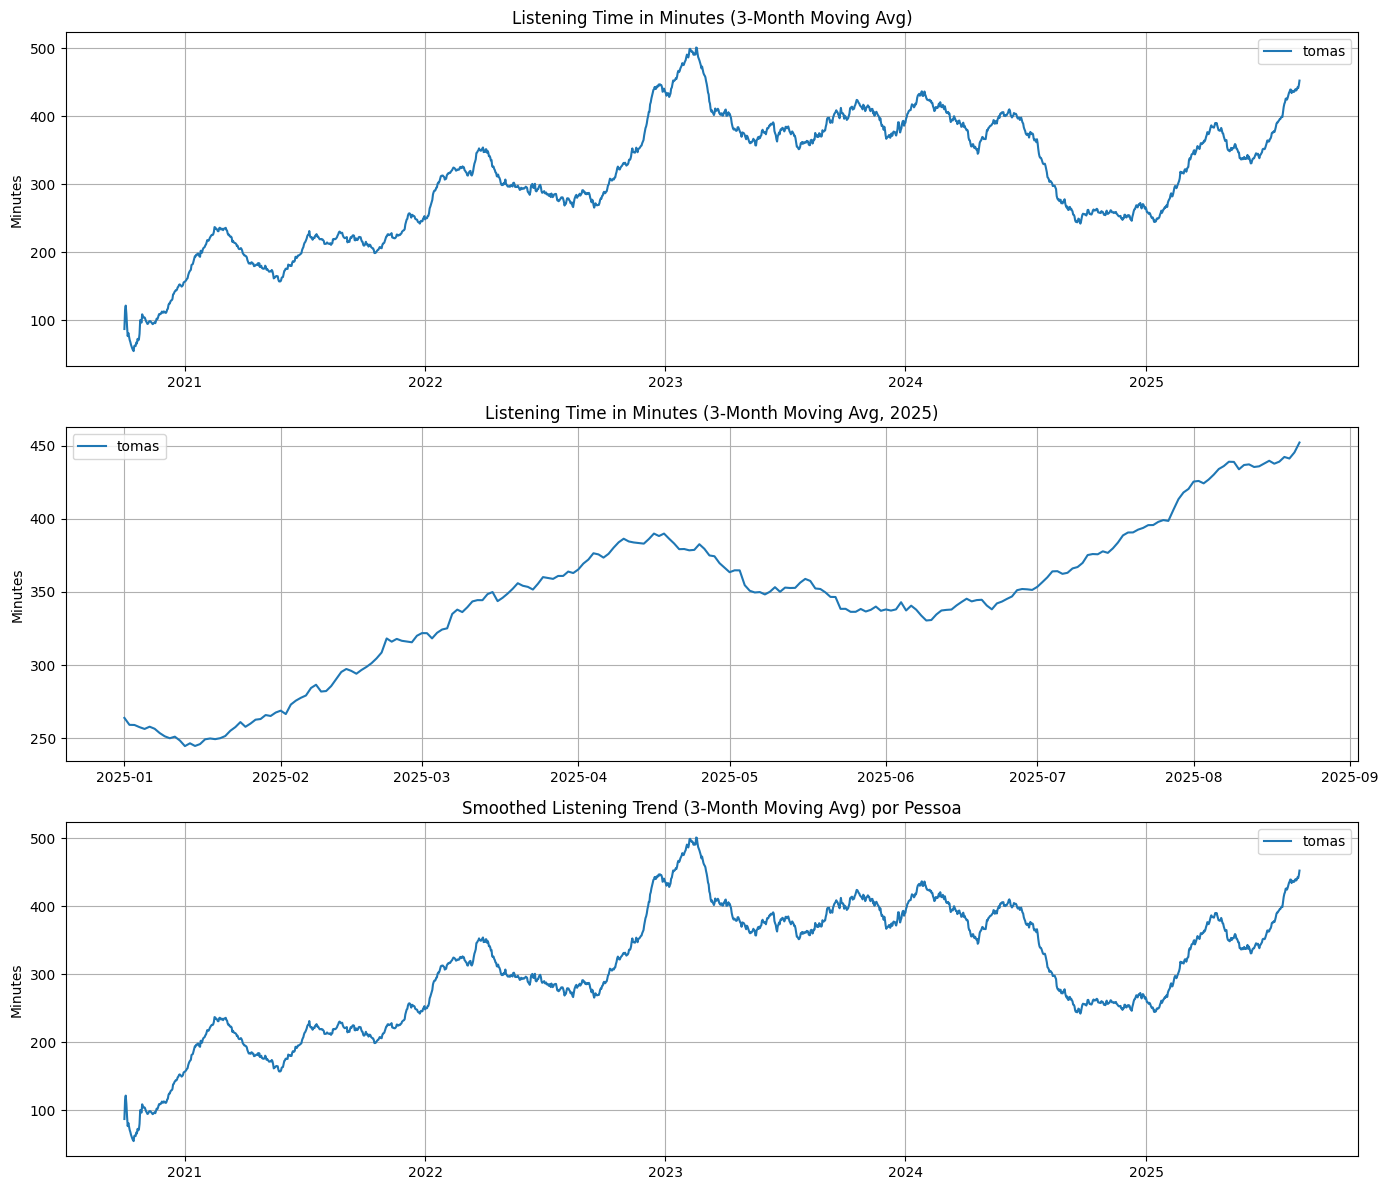

In [14]:
#Análise 3.1— Tendência de Escuta ao Longo do Tempo (Série temporal por minuto/hora/dia) -- POR USUARIO

# Flags para habilitar os gráficos principais
show_minutes = True
show_hours = False
show_days = False

# Agrupa por pessoa e dia, somando os minutos
daily_minutes_person = df_combined.groupby(['pessoa', df_combined['ts'].dt.date])['minutes_played'].sum().reset_index()
daily_minutes_person['ts'] = pd.to_datetime(daily_minutes_person['ts'])

# Calcula médias móveis de 3 meses (90 dias) por pessoa
daily_minutes_person['moving_avg_3_months'] = daily_minutes_person.groupby('pessoa')['minutes_played']\
    .transform(lambda x: x.rolling(window=90, min_periods=1).mean())
daily_minutes_person['hours_played'] = daily_minutes_person['moving_avg_3_months'] / 60
daily_minutes_person['days_played'] = daily_minutes_person['hours_played'] / 24

# Filtra apenas 2024 e 2025
daily_person_2024 = daily_minutes_person[daily_minutes_person['ts'].dt.year == 2024]
daily_person_2025 = daily_minutes_person[daily_minutes_person['ts'].dt.year == 2025]

# Contar quantos gráficos principais serão exibidos
num_main_plots = sum([show_minutes, show_hours, show_days])
num_total_plots = num_main_plots + 2  # adiciona os dois gráficos extras

# Criar subplots
fig, axs = plt.subplots(num_total_plots, 1, figsize=(14, 4 * num_total_plots), sharex=False)
if num_total_plots == 1:
    axs = [axs]

plot_index = 0

# --- Gráfico de minutos (apenas média móvel) ---
if show_minutes:
    for pessoa, group in daily_minutes_person.groupby('pessoa'):
        axs[plot_index].plot(group['ts'], group['moving_avg_3_months'], label=pessoa)
    axs[plot_index].set_title('Listening Time in Minutes (3-Month Moving Avg)')
    axs[plot_index].set_ylabel('Minutes')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# --- Gráfico de horas ---
if show_hours:
    for pessoa, group in daily_minutes_person.groupby('pessoa'):
        axs[plot_index].plot(group['ts'], group['hours_played'], label=pessoa)
    axs[plot_index].set_title('Listening Time in Hours (3-Month Moving Avg)')
    axs[plot_index].set_ylabel('Hours')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# --- Gráfico de dias ---
if show_days:
    for pessoa, group in daily_minutes_person.groupby('pessoa'):
        axs[plot_index].plot(group['ts'], group['days_played'], label=pessoa)
    axs[plot_index].set_title('Listening Time in Days (3-Month Moving Avg)')
    axs[plot_index].set_ylabel('Days')
    axs[plot_index].legend()
    axs[plot_index].grid(True)
    plot_index += 1

# --- Gráfico filtrado apenas para 2025 (média móvel minutos) ---
for pessoa, group in daily_person_2025.groupby('pessoa'):
    axs[plot_index].plot(group['ts'], group['moving_avg_3_months'], label=pessoa)
axs[plot_index].set_title('Listening Time in Minutes (3-Month Moving Avg, 2025)')
axs[plot_index].set_ylabel('Minutes')
axs[plot_index].legend()
axs[plot_index].grid(True)
plot_index += 1

# --- Gráfico apenas da média móvel geral ---
for pessoa, group in daily_minutes_person.groupby('pessoa'):
    axs[plot_index].plot(group['ts'], group['moving_avg_3_months'], label=pessoa)
axs[plot_index].set_title('Smoothed Listening Trend (3-Month Moving Avg) por Pessoa')
axs[plot_index].set_ylabel('Minutes')
axs[plot_index].legend()
axs[plot_index].grid(True)

plt.tight_layout()
plt.show()


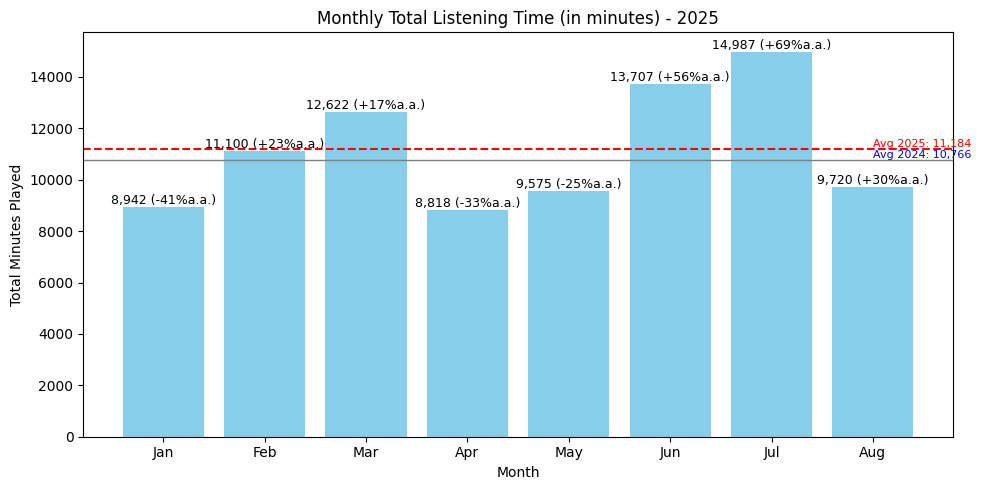

In [15]:
#Análise 4 — Tempo total 2025 x 2024 por mês e média total (qtd e variação % a.a.)

# Agrupar por mês e calcular soma total de minutos
monthly_sum_2024 = daily_minutes_2024.groupby(daily_minutes_2024['ts'].dt.month)['minutes_played'].sum().reset_index()
monthly_sum_2025 = daily_minutes_2025.groupby(daily_minutes_2025['ts'].dt.month)['minutes_played'].sum().reset_index()

# Renomear colunas
monthly_sum_2024.columns = ['month', 'minutes_played_2024']
monthly_sum_2025.columns = ['month', 'minutes_played_2025']

# Mesclar os dados por mês
monthly_sum = pd.merge(monthly_sum_2025, monthly_sum_2024, on='month', how='left')

# Calcular variação percentual
monthly_sum['variation'] = ((monthly_sum['minutes_played_2025'] - monthly_sum['minutes_played_2024']) / monthly_sum['minutes_played_2024']) * 100

# Calcular a Avg
mean_value = monthly_sum['minutes_played_2025'].mean()
mean_value2 = monthly_sum['minutes_played_2024'].mean()

# Criar rótulos de mês
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sum['month_label'] = monthly_sum['month'].apply(lambda x: month_labels[x-1])

# Plotar gráfico
plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_sum['month_label'], monthly_sum['minutes_played_2025'], color='skyblue')

# Adicionar os valores acima de cada barra com variação percentual
for i, bar in enumerate(bars):
    height = bar.get_height()
    variation = monthly_sum.loc[i, 'variation']
    if pd.notna(variation):
        label = f"{int(height):,} ({variation:+.0f}%a.a.)"
    else:
        label = f"{int(height):,} (N/A)"
    plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha='center', va='bottom', fontsize=9)

# Adicionar linha da Avg 2025
plt.axhline(y=mean_value, color='red', linestyle='--', linewidth=1.5)
if pd.notna(mean_value):
    plt.text(len(monthly_sum)-1, mean_value, f'Avg 2025: {int(mean_value):,}', color='red', va='bottom', ha='left', fontsize=8)

# Adicionar linha da Avg 2024
plt.axhline(y=mean_value2, color='gray', linestyle='-', linewidth=1)
if pd.notna(mean_value2):
    plt.text(len(monthly_sum)-1, mean_value2, f'Avg 2024: {int(mean_value2):,}', color='blue', va='bottom', ha='left', fontsize=8)


plt.title('Monthly Total Listening Time (in minutes) - 2025')
plt.xlabel('Month')
plt.ylabel('Total Minutes Played')
plt.tight_layout()
plt.show()


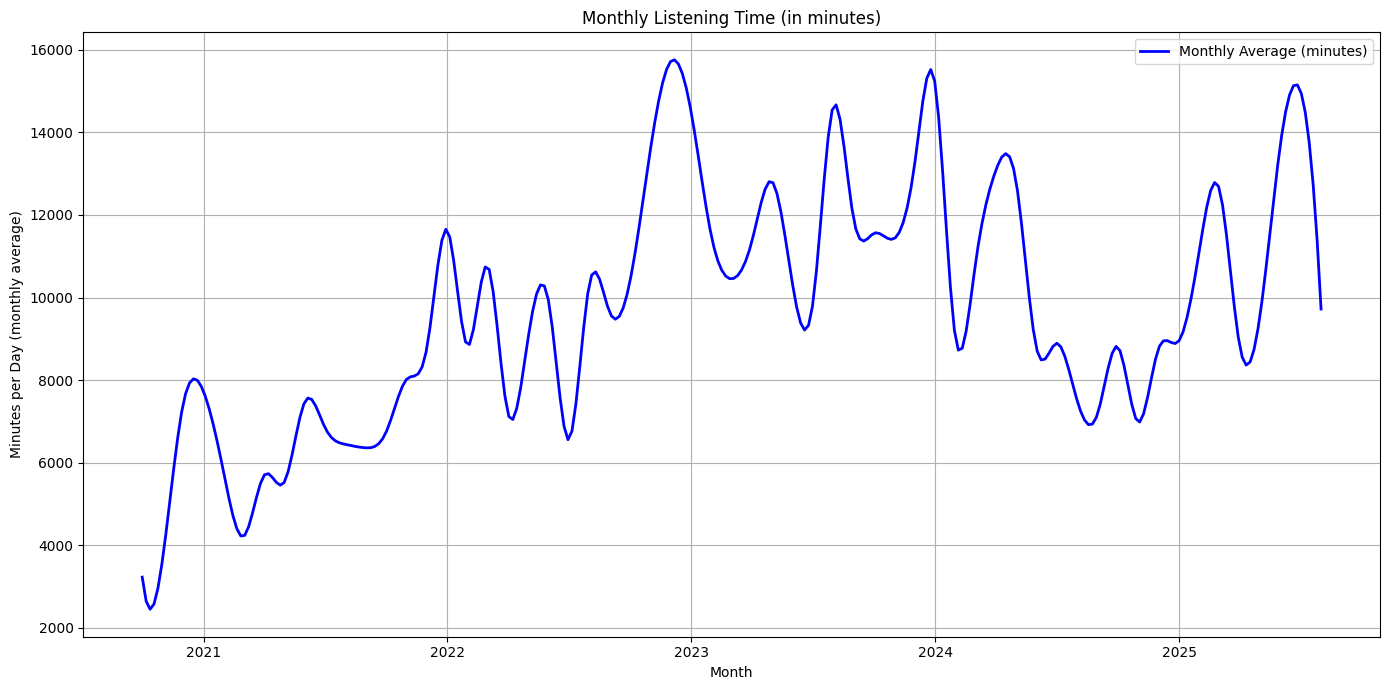

In [16]:
# Analise extra - Qtd escutada ao longo do tempo com interpolação para suavizar a linha


# Converter milissegundos para minutos
df_combined['minutes_played'] = df_combined['ms_played'] / (1000 * 60)

# Agrupar por mês e calcular soma
monthly_avg = df_combined.groupby(df_combined['ts'].dt.to_period('M'))['minutes_played'].sum().reset_index()
monthly_avg['ts'] = monthly_avg['ts'].dt.to_timestamp()

# Interpolação para suavizar a linha
x = np.arange(len(monthly_avg))
y = monthly_avg['minutes_played'].values
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_smooth)

# Mapear os timestamps para os valores interpolados
ts_smooth = np.linspace(monthly_avg['ts'].min().value, monthly_avg['ts'].max().value, 300)
ts_smooth = pd.to_datetime(ts_smooth)

# Plotar
plt.figure(figsize=(14, 7))
plt.plot(ts_smooth, y_smooth, color='blue', linewidth=2, label='Monthly Average (minutes)')

plt.title('Monthly Listening Time (in minutes)')
plt.xlabel('Month')
plt.ylabel('Minutes per Day (monthly average)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


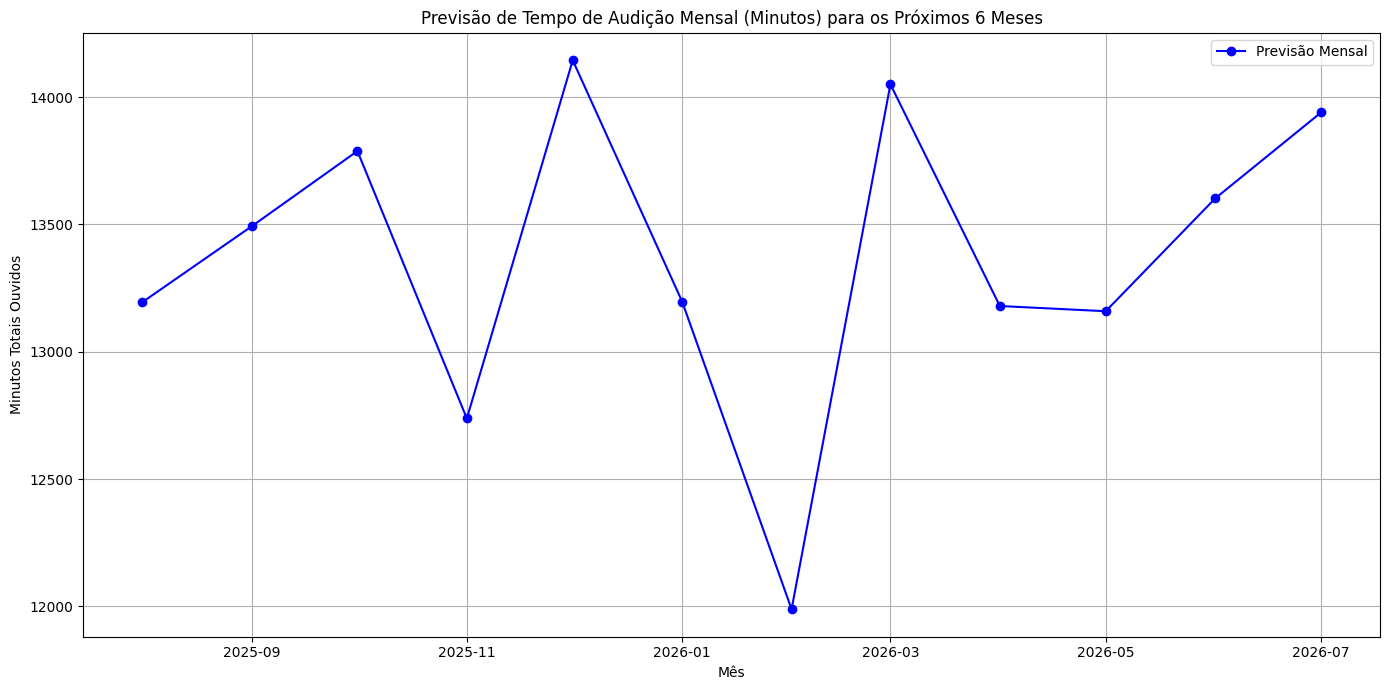

In [17]:
#Análise 5 — Previsao de escuta futura por mes com XGBOOST

# Preparar os dados
df_combined['ts'] = pd.to_datetime(df_combined['ts'])
df_combined['minutes_played'] = df_combined['ms_played'] / (1000 * 60)

# Agrupar por dia
df_daily = df_combined.groupby(df_combined['ts'].dt.date)['minutes_played'].sum().reset_index()
df_daily['ts'] = pd.to_datetime(df_daily['ts'])

# Excluir mês atual incompleto
latest_day = df_daily['ts'].max()
current_month = latest_day.month
current_year = latest_day.year
df_daily = df_daily[~((df_daily['ts'].dt.month == current_month) & (df_daily['ts'].dt.year == current_year))]

# Criar variáveis explicativas
df_daily['day_index'] = np.arange(len(df_daily))
df_daily['day_of_week'] = df_daily['ts'].dt.dayofweek
df_daily['month'] = df_daily['ts'].dt.month

# Separar features e target
X = df_daily[['day_index', 'day_of_week', 'month']]
y = df_daily['minutes_played']

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treinar modelo
model = XGBRegressor()
model.fit(X_scaled, y)

# Prever próximos 365 dias (~1 ano)
future_days = 365
last_index = df_daily['day_index'].max()
future_indices = np.arange(last_index + 1, last_index + future_days + 1)
future_dates = pd.date_range(start=df_daily['ts'].max() + pd.Timedelta(days=1), periods=future_days, freq='D')
future_day_of_week = future_dates.dayofweek
future_month = future_dates.month

# Criar DataFrame de previsão
X_future = pd.DataFrame({
    'day_index': future_indices,
    'day_of_week': future_day_of_week,
    'month': future_month
})
X_future_scaled = scaler.transform(X_future)
future_predictions = model.predict(X_future_scaled)

# Criar DataFrame com previsões
df_future = pd.DataFrame({'ts': future_dates, 'predicted_minutes': future_predictions})

# Agrupar por mês
monthly_projection = df_future.groupby(df_future['ts'].dt.to_period('M'))['predicted_minutes'].sum().reset_index()
monthly_projection['ts'] = monthly_projection['ts'].dt.to_timestamp()

# Plotar
plt.figure(figsize=(14, 7))
plt.plot(monthly_projection['ts'], monthly_projection['predicted_minutes'], marker='o', linestyle='-', color='blue', label='Previsão Mensal')
plt.title('Previsão de Tempo de Audição Mensal (Minutos) para os Próximos 6 Meses')
plt.xlabel('Mês')
plt.ylabel('Minutos Totais Ouvidos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


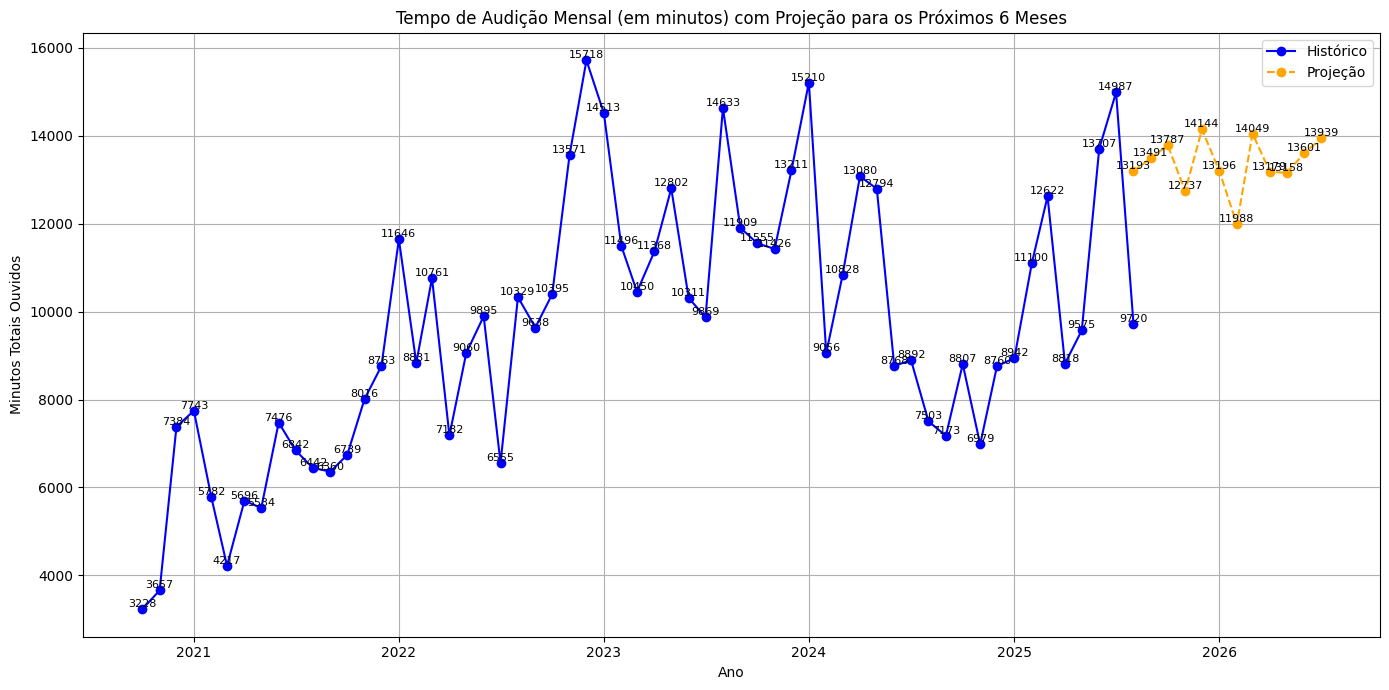

In [18]:
#Análise 5.1 — Adição do gráfico de Previsao de escuta futura por mes com XGBOOST na série temporal

# Preparar os dados
df_combined['ts'] = pd.to_datetime(df_combined['ts'])
df_combined['minutes_played'] = df_combined['ms_played'] / (1000 * 60)

# Agrupar por dia
df_daily = df_combined.groupby(df_combined['ts'].dt.date)['minutes_played'].sum().reset_index()
df_daily['ts'] = pd.to_datetime(df_daily['ts'])

# Excluir mês atual incompleto
latest_day = df_daily['ts'].max()
current_month = latest_day.month
current_year = latest_day.year
df_daily = df_daily[~((df_daily['ts'].dt.month == current_month) & (df_daily['ts'].dt.year == current_year))]

# Criar variáveis explicativas
df_daily['day_index'] = np.arange(len(df_daily))
df_daily['day_of_week'] = df_daily['ts'].dt.dayofweek
df_daily['month'] = df_daily['ts'].dt.month

# Separar features e target
X = df_daily[['day_index', 'day_of_week', 'month']]
y = df_daily['minutes_played']

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treinar modelo
model = XGBRegressor()
model.fit(X_scaled, y)

# Prever próximos 365 dias (~1 ano)
future_days = 365
last_index = df_daily['day_index'].max()
future_indices = np.arange(last_index + 1, last_index + future_days + 1)
future_dates = pd.date_range(start=df_daily['ts'].max() + pd.Timedelta(days=1), periods=future_days, freq='D')
future_day_of_week = future_dates.dayofweek
future_month = future_dates.month

# Criar DataFrame de previsão
X_future = pd.DataFrame({
    'day_index': future_indices,
    'day_of_week': future_day_of_week,
    'month': future_month
})
X_future_scaled = scaler.transform(X_future)
future_predictions = model.predict(X_future_scaled)

# Criar DataFrame com previsões
df_future = pd.DataFrame({'ts': future_dates, 'predicted_minutes': future_predictions})

# Agrupar histórico por mês
monthly_actual = df_combined.groupby(df_combined['ts'].dt.to_period('M'))['minutes_played'].sum().reset_index()
monthly_actual['ts'] = monthly_actual['ts'].dt.to_timestamp()

# Agrupar projeções por mês
monthly_projection = df_future.groupby(df_future['ts'].dt.to_period('M'))['predicted_minutes'].sum().reset_index()
monthly_projection['ts'] = monthly_projection['ts'].dt.to_timestamp()

### Plotar gráfico combinado ### 
plt.figure(figsize=(14, 7))
plt.plot(monthly_actual['ts'], monthly_actual['minutes_played'], marker='o', linestyle='-', color='blue', label='Histórico')
plt.plot(monthly_projection['ts'], monthly_projection['predicted_minutes'], marker='o', linestyle='--', color='orange', label='Projeção')
# Adicionar valores acima dos pontos históricos
for x, y in zip(monthly_actual['ts'], monthly_actual['minutes_played']):
    plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)
# Adicionar valores acima dos pontos projetados
for x, y in zip(monthly_projection['ts'], monthly_projection['predicted_minutes']):
    plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=8)
plt.title('Tempo de Audição Mensal (em minutos) com Projeção para os Próximos 6 Meses')
plt.xlabel('Ano')
plt.ylabel('Minutos Totais Ouvidos')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.grid(False)
plt.show()


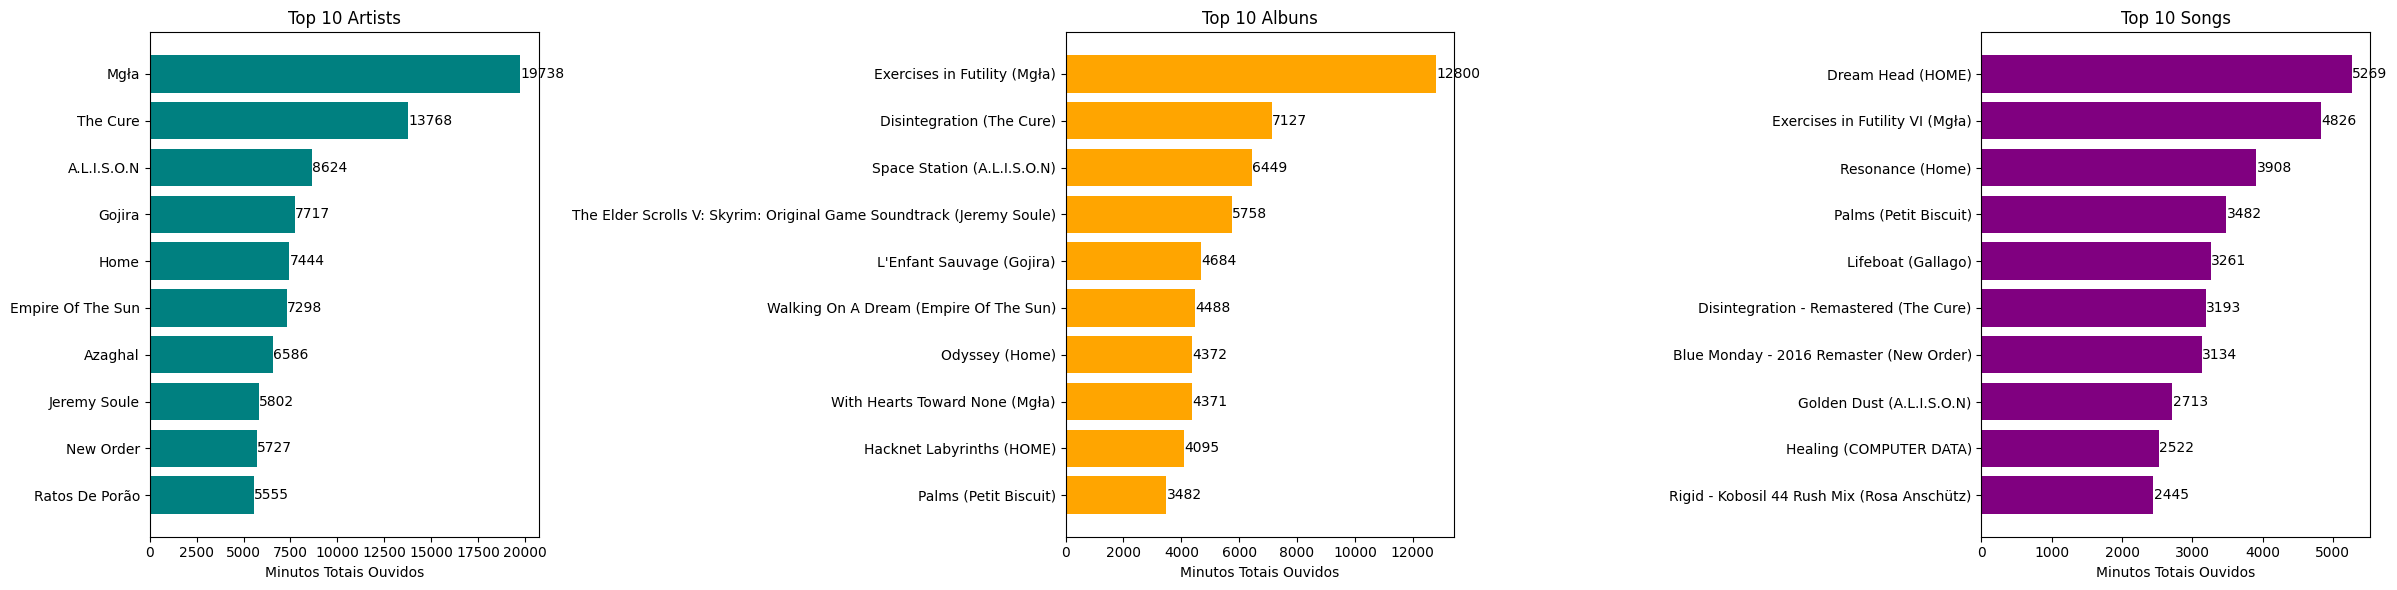

In [19]:
#Análise 6 — Top 10 Artistas, Álbuns e Músicas - com possibilidade de filtro de ano

# Escolha se quer filtrar por ano ou não:
# Para ver apenas o ano de 2025, descomente a linha abaixo:
# df_filtered = df_combined[df_combined['ts'].dt.year == 2025]

# Para ver todos os anos, use esta linha:
df_filtered = df_combined.copy()

# Agrupar por artista
artist_sum = df_filtered.groupby('master_metadata_album_artist_name')['minutes_played'].sum().reset_index()
artist_sum = artist_sum.sort_values(by='minutes_played', ascending=False).head(10)

# Agrupar por álbum com nome do artista
album_sum = df_filtered.groupby(['master_metadata_album_album_name', 'master_metadata_album_artist_name'])['minutes_played'].sum().reset_index()
album_sum['label'] = album_sum['master_metadata_album_album_name'] + ' (' + album_sum['master_metadata_album_artist_name'] + ')'
album_sum = album_sum.sort_values(by='minutes_played', ascending=False).head(10)

# Agrupar por música com nome do artista
track_sum = df_filtered.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name'])['minutes_played'].sum().reset_index()
track_sum['label'] = track_sum['master_metadata_track_name'] + ' (' + track_sum['master_metadata_album_artist_name'] + ')'
track_sum = track_sum.sort_values(by='minutes_played', ascending=False).head(10)

# Criar gráficos de barras horizontais
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Gráfico por artista
axs[0].barh(artist_sum['master_metadata_album_artist_name'], artist_sum['minutes_played'], color='teal')
axs[0].set_title('Top 10 Artists')
axs[0].set_xlabel('Minutos Totais Ouvidos')
axs[0].invert_yaxis()
# axs[0].grid(axis='x')
for i, v in enumerate(artist_sum['minutes_played']):
    axs[0].text(v + 5, i, str(int(v)), va='center')

# Gráfico por álbum
axs[1].barh(album_sum['label'], album_sum['minutes_played'], color='orange')
axs[1].set_title('Top 10 Albuns')
axs[1].set_xlabel('Minutos Totais Ouvidos')
axs[1].invert_yaxis()
# axs[1].grid(axis='x')
for i, v in enumerate(album_sum['minutes_played']):
    axs[1].text(v + 5, i, str(int(v)), va='center')

# Gráfico por música
axs[2].barh(track_sum['label'], track_sum['minutes_played'], color='purple')
axs[2].set_title('Top 10 Songs')
axs[2].set_xlabel('Minutos Totais Ouvidos')
axs[2].invert_yaxis()
# axs[2].grid(axis='x')
for i, v in enumerate(track_sum['minutes_played']):
    axs[2].text(v + 5, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()


In [20]:
#Analise Extra - TOP 10 ARTISTAS POR ANO - MATRIZ

# Extrair o ano da coluna de timestamp
df_combined['year'] = df_combined['ts'].dt.year

# Agrupar por ano e artista, somando os minutos ouvidos
artist_yearly_sum = df_combined.groupby(['year', 'master_metadata_album_artist_name'])['minutes_played'].sum().reset_index()

# Para cada ano, selecionar os 10 artistas mais escutados
top_artists_per_year = (
    artist_yearly_sum.groupby('year', group_keys=False)
    .apply(lambda x: x.nlargest(10, 'minutes_played'))
)

# Criar uma tabela com artistas como linhas e anos como colunas
pivot_table = top_artists_per_year.pivot_table(
    index='master_metadata_album_artist_name',
    columns='year',
    values='minutes_played',
    fill_value=0
)

# Ordenar pela última coluna (ano mais recente), do maior para o menor
last_year = pivot_table.columns.max()
pivot_table_sorted = pivot_table.sort_values(by=last_year, ascending=False)

# Exibir a tabela ordenada
pivot_table_sorted


year                                     2020         2021         2022  \
master_metadata_album_artist_name                                         
Mgła                                 0.000000  1865.092017  5332.189883   
Empire Of The Sun                    0.000000     0.000000     0.000000   
The Cure                           379.867733  1923.483267  2827.750350   
Desestresse                          0.000000  1435.560517     0.000000   
Petit Biscuit                        0.000000     0.000000     0.000000   
Azaghal                              0.000000     0.000000  1874.749083   
Lane 8                               0.000000     0.000000     0.000000   
A.L.I.S.O.N                          0.000000  1153.421817     0.000000   
Home                               303.123067     0.000000     0.000000   
oDDling                              0.000000     0.000000     0.000000   
COMPUTER DATA                      302.841717     0.000000     0.000000   
Batushka                             0.000000     0.000000     0.000000   
Agalloch                             0.000000     0.000000  1284.747300   
AIROD                              346.984883     0.000000     0.000000   
HOME                                 0.000000     0.000000  1913.796750   
Gojira                               0.000000  1298.240300  2291.844200   
Gallago                              0.000000   925.329367     0.000000   
GOOSE                              256.356933     0.000000     0.000000   
Forhill                              0.000000     0.000000     0.000000   
Moderat                            334.559083     0.000000     0.000000   
Kidnap                             624.540217     0.000000     0.000000   
Jeremy Soule                         0.000000  2239.375533  2460.992600   
PATRIARKH                            0.000000     0.000000  2777.741517   
No_4mat                              0.000000   937.443017     0.000000   
New Order                            0.000000     0.000000  1488.667717   
Ratos De Porão                     267.486583  1410.444767  1612.313917   
Rosa Anschütz                        0.000000   834.295683     0.000000   
Uppermost                          310.863617     0.000000     0.000000   
Victor Lou                         353.619783     0.000000     0.000000   
Windows 96                           0.000000     0.000000     0.000000   

year                                      2023         2024         2025  
master_metadata_album_artist_name                                         
Mgła                               4310.819833  5130.642033  3042.354117  
Empire Of The Sun                     0.000000  3008.290167  2309.811350  
The Cure                           3641.613550  3225.362300  1770.308700  
Desestresse                           0.000000     0.000000  1549.756200  
Petit Biscuit                         0.000000  1942.991333  1342.070367  
Azaghal                            2692.620517     0.000000  1058.248600  
Lane 8                                0.000000     0.000000   957.132250  
A.L.I.S.O.N                        3360.035517  1967.361000   907.197067  
Home                               3179.098717  1424.587217   861.303400  
oDDling                            1894.459967     0.000000   813.840283  
COMPUTER DATA                         0.000000     0.000000     0.000000  
Batushka                           2247.136483     0.000000     0.000000  
Agalloch                              0.000000     0.000000     0.000000  
AIROD                                 0.000000     0.000000     0.000000  
HOME                               1699.314783  1030.077383     0.000000  
Gojira                                0.000000  1773.578017     0.000000  
Gallago                               0.000000     0.000000     0.000000  
GOOSE                                 0.000000     0.000000     0.000000  
Forhill                            1832.347133     0.000000     0.000000  
Moderat                 

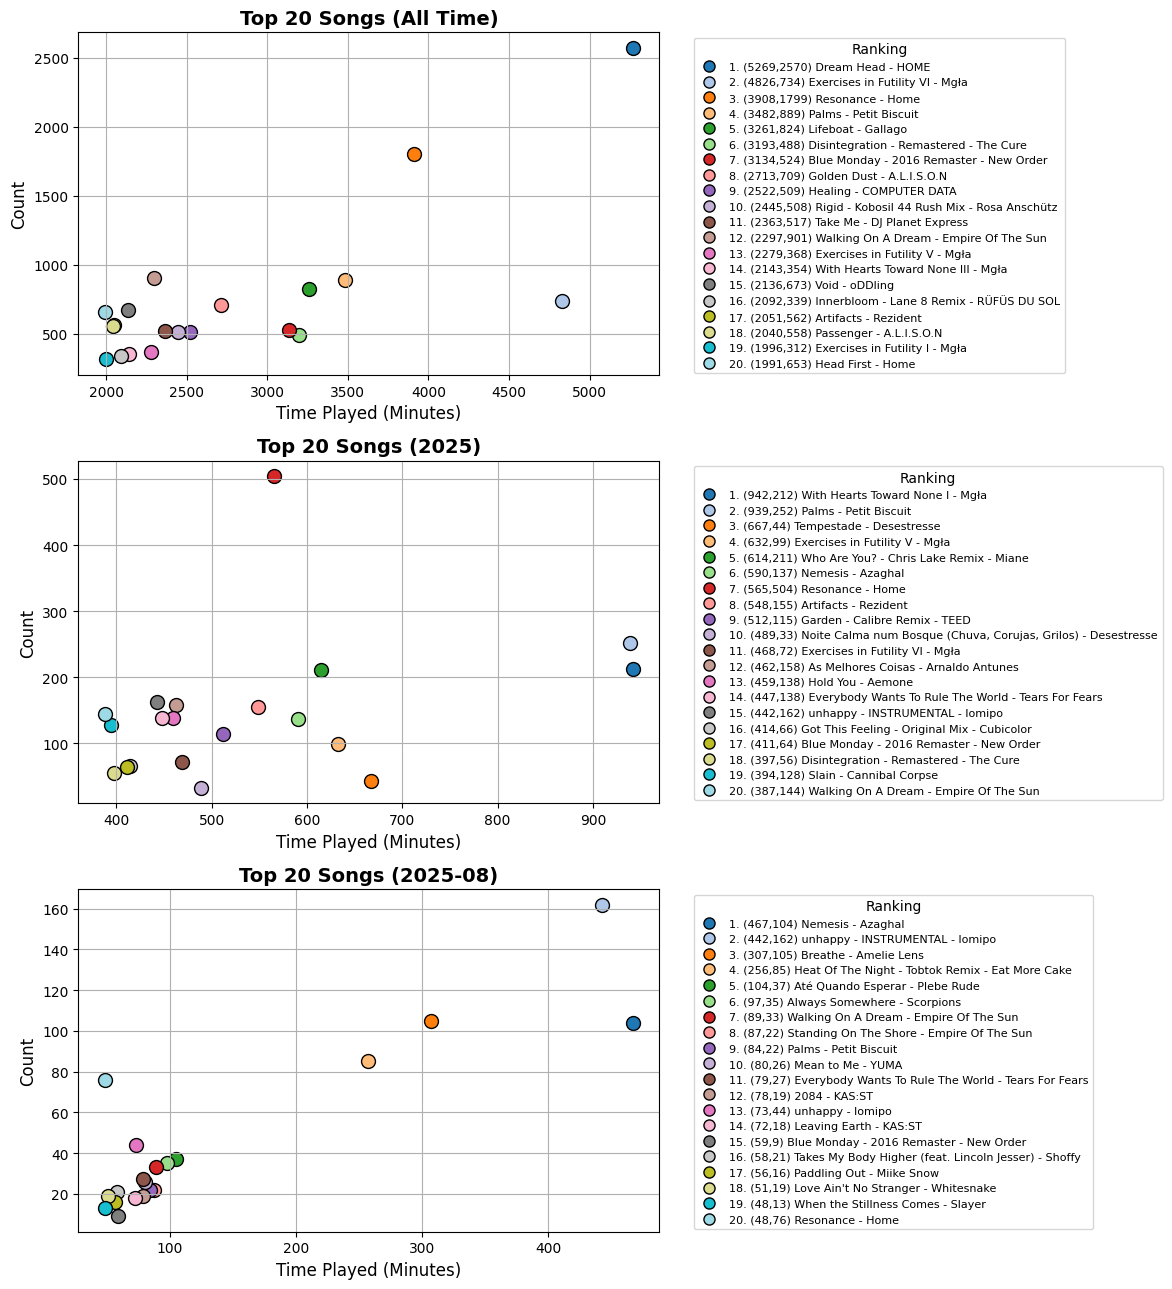

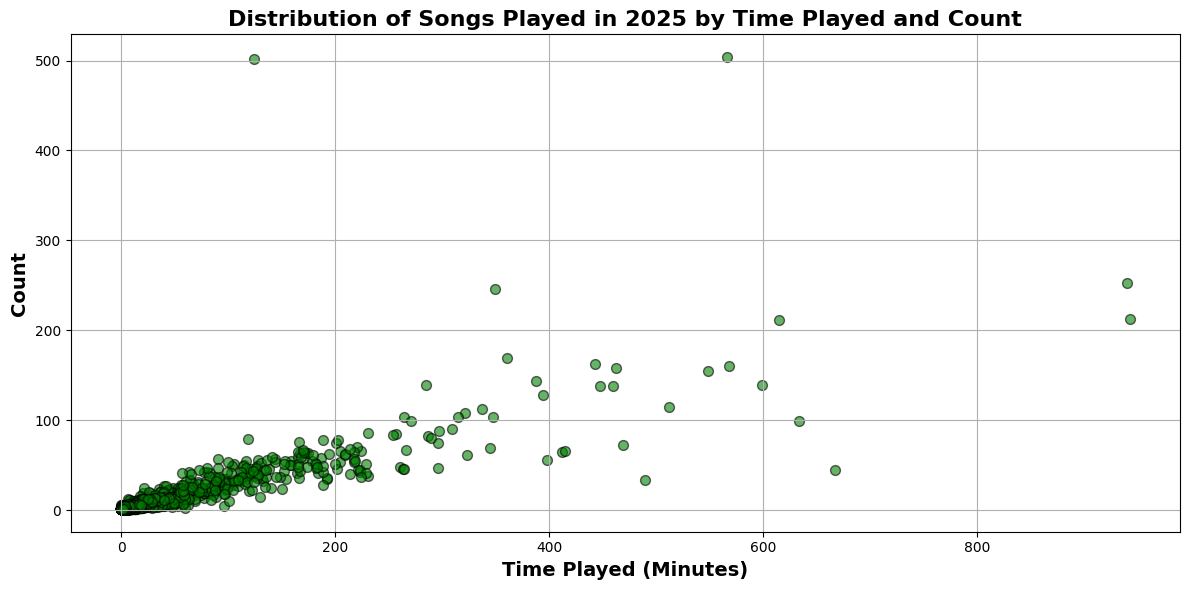

In [21]:
#Análise 7 — GRAFICOS DE DISPERSAO Top 20 músicas mais escutadas — Geral, 2025 e último mês fechado Distribuição de todas as músicas escutadas em 2025

# Função para gerar os dados agregados
def get_top_20(df, title):
    grouped = df.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name']).agg({
        'ms_played': 'sum',
        'master_metadata_track_name': 'count'
    }).rename(columns={'master_metadata_track_name': 'count'}).reset_index()
    grouped['time_played_minutes'] = grouped['ms_played'] / (1000 * 60)
    top_20 = grouped.sort_values(by='time_played_minutes', ascending=False).head(20)
    return top_20, title

# Dados gerais
top_20_all, title_all = get_top_20(df_combined, 'Top 20 Songs (All Time)')

# Dados de 2025
df_2025 = df_combined[df_combined['ts'].dt.year == 2025]
top_20_2025, title_2025 = get_top_20(df_2025, 'Top 20 Songs (2025)')

# Dados do último mês fechado
today = pd.Timestamp.today()
last_closed_month = (today.replace(day=1) - pd.Timedelta(days=1)).to_period('M')
df_last_month = df_combined[df_combined['ts'].dt.to_period('M') == last_closed_month]
top_20_month, title_month = get_top_20(df_last_month, f'Top 20 Songs ({last_closed_month})')

# Preparar subplots empilhados verticalmente
fig, axes = plt.subplots(3, 1, figsize=(12, 13))

datasets = [(top_20_all, title_all), (top_20_2025, title_2025), (top_20_month, title_month)]

for ax, (data, title) in zip(axes, datasets):
    colors = plt.cm.tab20.colors
    for i, row in enumerate(data.itertuples(index=False)):
        ax.scatter(row.time_played_minutes, row.count, s=100, color=colors[i], edgecolors='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Played (Minutes)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(True)

    # Criar legenda personalizada com dados antes do nome e incluir artista
    legend_labels = [
        f"{i+1}. ({int(row.time_played_minutes)},{row.count}) {row.master_metadata_track_name} - {row.master_metadata_album_artist_name}"
        for i, row in enumerate(data.itertuples(index=False))
    ]
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=colors[i], markersize=8, markeredgecolor='black')
               for i, label in enumerate(legend_labels)]
    ax.legend(handles=handles, title='Ranking', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

## GRAFICO DE TODAS AS MUSICAS DO ANO INTEIRO

# Filtrar apenas músicas tocadas em 2025
df_2025 = df_combined[df_combined['ts'].dt.year == 2025]

# Agrupar por nome da música e calcular soma do tempo e contagem
songs_2025 = df_2025.groupby('master_metadata_track_name').agg({
    'ms_played': 'sum',
    'master_metadata_track_name': 'count'
}).rename(columns={'master_metadata_track_name': 'count'}).reset_index()

# Converter tempo para minutos
songs_2025['time_played_minutes'] = songs_2025['ms_played'] / (1000 * 60)

# Criar gráfico de dispersão simples para músicas de 2025
plt.figure(figsize=(12, 6))
plt.scatter(
    songs_2025['time_played_minutes'],
    songs_2025['count'],
    s=50,
    color='green',
    edgecolors='black',
    alpha=0.6
)

plt.xlabel('Time Played (Minutes)', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Songs Played in 2025 by Time Played and Count', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


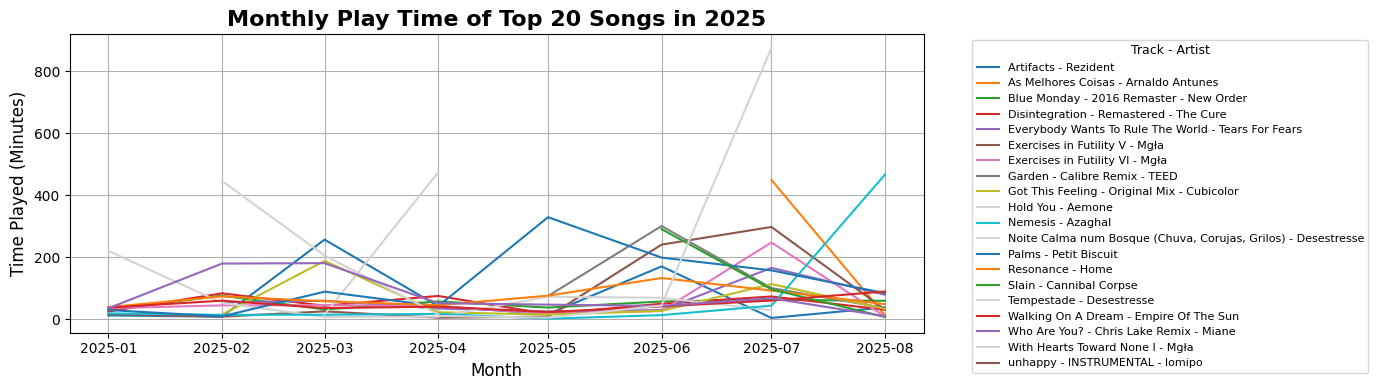

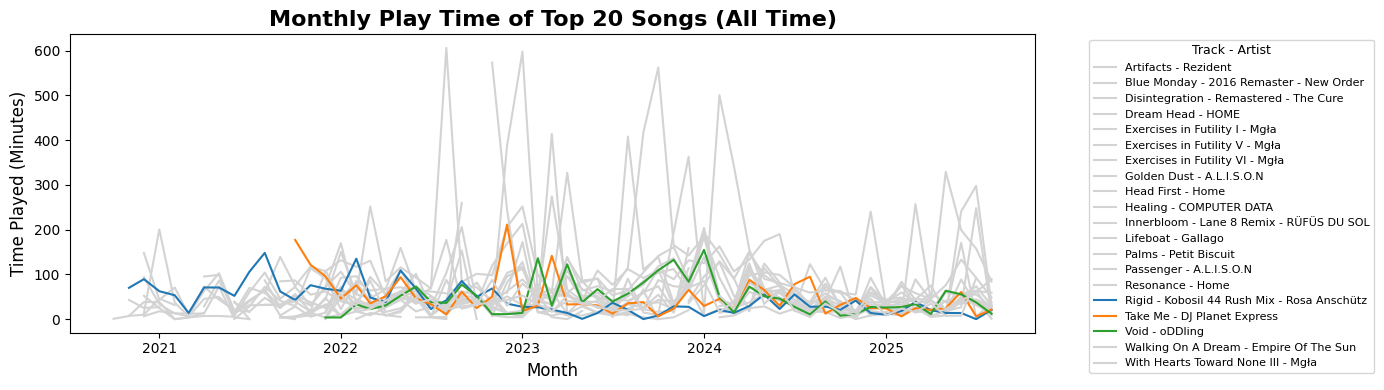

In [22]:
#Análise 8 — Evolução Mensal das Top 20 Músicas de 2025 (Fieldade às músicas e estilo preferido)

def prepare_monthly_play_data(df, top_tracks):
    # Filtra o DataFrame para manter apenas as músicas presentes na lista de top_tracks
    df_filtered = df.merge(
        top_tracks[['master_metadata_track_name', 'master_metadata_album_artist_name']],
        on=['master_metadata_track_name', 'master_metadata_album_artist_name']
    )

    # Cria uma nova coluna com o mês da reprodução
    df_filtered['month'] = df_filtered['ts'].dt.to_period('M')

    # Agrupa por mês, nome da música e artista, somando o tempo total de reprodução
    monthly_play = (
        df_filtered.groupby(['month', 'master_metadata_track_name', 'master_metadata_album_artist_name'])['ms_played']
        .sum()
        .reset_index()
    )

    # Converte o tempo de reprodução de milissegundos para minutos
    monthly_play['time_played_minutes'] = monthly_play['ms_played'] / (1000 * 60)

    # Cria uma coluna combinada com nome da música e artista para usar como legenda
    monthly_play['track_artist'] = monthly_play['master_metadata_track_name'] + ' - ' + monthly_play['master_metadata_album_artist_name']

    # Transforma o DataFrame em formato de série temporal, com meses como índice e músicas como colunas
    pivot_df = monthly_play.pivot(index='month', columns='track_artist', values='time_played_minutes')

    return pivot_df

def identify_incomplete_tracks(pivot_df):
    incomplete_tracks = []

    # Itera sobre cada música (coluna) no DataFrame pivotado
    for track in pivot_df.columns:
        track_series = pivot_df[track]

        # Identifica o primeiro mês em que a música foi tocada
        first_month = track_series.first_valid_index()

        # Verifica se há meses com valores ausentes após o primeiro mês de reprodução
        active_period = track_series.loc[first_month:]
        if active_period.isna().any():
            incomplete_tracks.append(track)

    return incomplete_tracks

def plot_monthly_play(pivot_df, incomplete_tracks, title, show_grid=True):
    # Define o tamanho da figura
    plt.figure(figsize=(14, 4))

    # Plota cada música como uma linha no gráfico
    for column in pivot_df.columns:
        # Se a música for incompleta, usa cor cinza claro
        color = 'lightgray' if column in incomplete_tracks else None
        plt.plot(pivot_df.index.to_timestamp(), pivot_df[column], label=column, color=color, marker='')

    # Define título e rótulos dos eixos
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Time Played (Minutes)', fontsize=12)

    # Exibe a grade se show_grid for True
    if show_grid:
        plt.grid(True)

    # Adiciona legenda com título e formatação
    plt.legend(title='Track - Artist', fontsize=8, title_fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Filtra os dados apenas para o ano de 2025
df_2025 = df_combined[df_combined['ts'].dt.year == 2025]

# Prepara os dados mensais de reprodução para as top 20 músicas de 2025
pivot_df_2025 = prepare_monthly_play_data(df_2025, top_20_2025)

# Identifica quais músicas não foram tocadas em todos os meses após sua primeira reprodução
incomplete_tracks_2025 = identify_incomplete_tracks(pivot_df_2025)

# Plota o gráfico para as top 20 músicas de 2025
plot_monthly_play(pivot_df_2025, incomplete_tracks_2025, 'Monthly Play Time of Top 20 Songs in 2025')

# Agrupa os dados para encontrar as 20 músicas mais tocadas em todos os anos
top_20_all_tracks = (
    df_combined.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name'])
    .agg({'ms_played': 'sum'})
    .sort_values(by='ms_played', ascending=False)
    .head(20)
    .reset_index()
)

# Prepara os dados mensais de reprodução para essas músicas
pivot_df_all = prepare_monthly_play_data(df_combined, top_20_all_tracks)

# Identifica músicas com reprodução incompleta ao longo dos meses
incomplete_tracks_all = identify_incomplete_tracks(pivot_df_all)

# Plota o gráfico para as top 20 músicas de todos os tempos
plot_monthly_play(pivot_df_all, incomplete_tracks_all, 'Monthly Play Time of Top 20 Songs (All Time)', show_grid=False)



In [23]:
## METODOLOGIA WRAPPED TOP 100 - Ponderando qtd e tempo e criando um índice 0-1

# Agrupar todas as músicas por nome e artista, somando tempo e contando execuções
all_songs = df_combined.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name']).agg({
    'ms_played': 'sum',
    'master_metadata_track_name': 'count'
}).rename(columns={'master_metadata_track_name': 'count'}).reset_index()

# Converter tempo para minutos
all_songs['time_played_minutes'] = all_songs['ms_played'] / (1000 * 60)

# Criar ranking total com base no tempo
all_songs = all_songs.sort_values(by='time_played_minutes', ascending=False).reset_index(drop=True)
all_songs['Ranking'] = all_songs.index + 1

# Calcular índice normalizado para tempo e quantidade
tempo_min = all_songs['time_played_minutes'].min()
tempo_max = all_songs['time_played_minutes'].max()
qtd_min = all_songs['count'].min()
qtd_max = all_songs['count'].max()

all_songs['indice_tempo'] = (all_songs['time_played_minutes'] - tempo_min) / (tempo_max - tempo_min)
all_songs['indice_qtd'] = (all_songs['count'] - qtd_min) / (qtd_max - qtd_min)

# Índice final como multiplicação dos dois índices
all_songs['indice_final'] = all_songs['indice_tempo'] * all_songs['indice_qtd']


# Arredondar para 2 casas decimais
all_songs['time_played_minutes'] = all_songs['time_played_minutes'].round(2)
all_songs['indice_tempo'] = all_songs['indice_tempo'].round(2)
all_songs['indice_qtd'] = all_songs['indice_qtd'].round(2)
all_songs['indice_final'] = all_songs['indice_final'].round(2)


# Exibir a tabela final
all_songs[['Ranking', 'count', 'time_played_minutes', 'master_metadata_track_name',
                   'master_metadata_album_artist_name', 'indice_tempo', 'indice_qtd', 'indice_final']]

# Ordenar a tabela pelo índice_final em ordem decrescente
sorted_songs = all_songs.sort_values(by='indice_final', ascending=False)

# Selecionar as colunas desejadas
selected_columns = [
    'Ranking',
    'count',
    'time_played_minutes',
    'master_metadata_track_name',
    'master_metadata_album_artist_name',
    'indice_tempo',
    'indice_qtd',
    'indice_final'
]

# Exibir a tabela ordenada
#sorted_songs[selected_columns].

sorted_songs = sorted_songs.sort_values('indice_final', ascending=False)

sorted_songs.reset_index().drop(columns=['index']).reset_index()


index                         master_metadata_track_name  \
0          0                                         Dream Head   
1          1                                          Resonance   
2          2                           Exercises in Futility VI   
3          3                                              Palms   
4          4                                           Lifeboat   
...      ...                                                ...   
23665  23665                            Blues for the Night Owl   
23666  23666                                            Wake Up   
23667  23667                                     Necropedophile   
23668  23668  Violin Concerto No. 1 in A minor, BWV 1041: I....   
23669  23669                                As Far As I Can See   

      master_metadata_album_artist_name  ms_played  count  \
0                                  HOME  316150743   2570   
1                                  Home  234510528   1799   
2                                  Mgła  289585211    734   
3                         Petit Biscuit  208950438    889   
4                               Gallago  195693613    824   
...                                 ...        ...    ...   
23665                      Ramsey Lewis          0      1   
23666                              SwuM          0      1   
23667                   Cannibal Corpse          0      1   
23668             Johann Sebastian Bach          0      1   
23669                        Phantogram     141952      1   

       time_played_minutes  Ranking  indice_tempo  indice_qtd  indice_final  
0                  5269.18        1          1.00        1.00          1.00  
1                  3908.51        3          0.74        0.70          0.52  
2                  4826.42        2          0.92        0.29          0.26  
3                  3482.51        4          0.66        0.35          0.23  
4                  3261.56        5          0.62        0.32          0.20  
...                    ...      ...           ...         ...           ...  
23665                 0.00    23666          0.00        0.00          0.00  
23666                 0.00    23667          0.00        0.00          0.00  
23667                 0.00    23668          0.00        0.00          0.00  
23668                 0.00    23669          0.00        0.00          0.00  
23669                 2.37    17754          0.00        0.00          0.00  

[23670 rows x 10 columns]

In [24]:
#Análise 11 — Top artistas mais influentes, baseada no índice criado - todos os tempos 

# Criar um novo DataFrame com as 100 músicas de maior RANKING
# top_100_songs = all_songs[all_songs['Ranking'] <= 100].copy()

# Selecionar as 100 músicas com maior INDICE_FINAL
top_100_songs = sorted_songs.head(100).copy()


# Selecionar as colunas desejadas
selected_columns = [
    'Ranking',
    'count',
    'time_played_minutes',
    'master_metadata_track_name',
    'master_metadata_album_artist_name'
]

# Exibir o DataFrame resultante
top_100_songs[selected_columns]

# Agrupar por artista e calcular:
# - número de músicas (linhas)
# - soma da coluna 'count'
# - soma da coluna 'time_played_minutes'

# Criar uma nova coluna com o nome do artista em maiúsculo
top_100_songs['master_metadata_album_artist_name_upper'] = top_100_songs['master_metadata_album_artist_name'].str.upper()

# Agrupar pelo nome do artista em maiúsculo e calcular as métricas
artist_summary = top_100_songs.groupby('master_metadata_album_artist_name_upper').agg(
    qtd_musicas=('master_metadata_track_name', 'count'),
    qtd_plays=('count', 'sum'),
    soma_tempo=('time_played_minutes', 'sum')
).reset_index()

# Arredondar a coluna de tempo para 2 casas decimais
artist_summary['soma_tempo'] = artist_summary['soma_tempo'].round(2)

# Ordenar pela soma do tempo escutado em ordem decrescente
artist_summary_sorted = artist_summary.sort_values(by='soma_tempo', ascending=False)

# Exibir o resultado
artist_summary_sorted 



master_metadata_album_artist_name_upper  qtd_musicas  qtd_plays  soma_tempo
37                                    MGŁA            8       2761    16194.91
25                                    HOME            3       5022    11169.41
61                                THE CURE            4       1580     7228.49
0                              A.L.I.S.O.N            3       1644     5914.32
23                                  GOJIRA            4       1707     4972.06
..                                     ...          ...        ...         ...
60                         TEARS FOR FEARS            1        182      601.23
40                              MIIKE SNOW            1        198      595.65
14                DJ CINÉMA QUARTIER LATIN            1        146      508.75
16                               DRIP-DROP            1        188      498.31
62                               THE DRUMS            1        144      488.96

[70 rows x 4 columns]

In [25]:
#Análise 11.1 — Top artistas mais influentes, baseada no índice criado - apenas 2025

# Filtrar o DataFrame para incluir apenas registros do ano desejado
df_ano = df_combined[df_combined['ts'].dt.year == 2025].copy()

# Agrupar todas as músicas por nome e artista, somando tempo e contando execuções
all_songs = df_ano.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name']).agg({
    'ms_played': 'sum',
    'master_metadata_track_name': 'count'
}).rename(columns={'master_metadata_track_name': 'count'}).reset_index()

# Converter tempo para minutos
all_songs['time_played_minutes'] = all_songs['ms_played'] / (1000 * 60)

# Criar ranking total com base no tempo
all_songs = all_songs.sort_values(by='time_played_minutes', ascending=False).reset_index(drop=True)
all_songs['Ranking'] = all_songs.index + 1

# Calcular índice normalizado para tempo e quantidade
tempo_min = all_songs['time_played_minutes'].min()
tempo_max = all_songs['time_played_minutes'].max()
qtd_min = all_songs['count'].min()
qtd_max = all_songs['count'].max()

all_songs['indice_tempo'] = (all_songs['time_played_minutes'] - tempo_min) / (tempo_max - tempo_min)
all_songs['indice_qtd'] = (all_songs['count'] - qtd_min) / (qtd_max - qtd_min)

# Índice final como multiplicação dos dois índices
all_songs['indice_final'] = all_songs['indice_tempo'] * all_songs['indice_qtd']

# Arredondar para 2 casas decimais
all_songs[['time_played_minutes', 'indice_tempo', 'indice_qtd', 'indice_final']] = all_songs[[
    'time_played_minutes', 'indice_tempo', 'indice_qtd', 'indice_final'
]].round(2)

# Ordenar pelo índice final
sorted_songs = all_songs.sort_values(by='indice_final', ascending=False)

# Selecionar as 100 músicas com maior índice_final
top_100_songs = sorted_songs.head(100).copy()

# Criar coluna com nome do artista em maiúsculo
top_100_songs['master_metadata_album_artist_name_upper'] = top_100_songs['master_metadata_album_artist_name'].str.upper()

# Agrupar por artista
artist_summary = top_100_songs.groupby('master_metadata_album_artist_name_upper').agg(
    qtd_musicas=('master_metadata_track_name', 'count'),
    qtd_plays=('count', 'sum'),
    soma_tempo=('time_played_minutes', 'sum')
).reset_index()

# Arredondar tempo
artist_summary['soma_tempo'] = artist_summary['soma_tempo'].round(2)

# Ordenar por tempo escutado
artist_summary_sorted = artist_summary.sort_values(by='soma_tempo', ascending=False)

# Exibir resultado final
artist_summary_sorted





master_metadata_album_artist_name_upper  qtd_musicas  qtd_plays  soma_tempo
37                                    MGŁA            4        421     2274.23
17                       EMPIRE OF THE SUN            6        488     1425.67
12                             DESESTRESSE            2         77     1156.46
52                           PETIT BISCUIT            2        300     1113.15
65                                THE CURE            3        139      849.53
..                                     ...          ...        ...         ...
54                              PLEBE RUDE            1         55      159.08
29                                     KCG            1         53      143.94
41                  MILIONÁRIO & JOSÉ RICO            1         59      140.73
42                                    MOYO            1         56      136.49
30                              KID ABELHA            1        502      123.72

[75 rows x 4 columns]

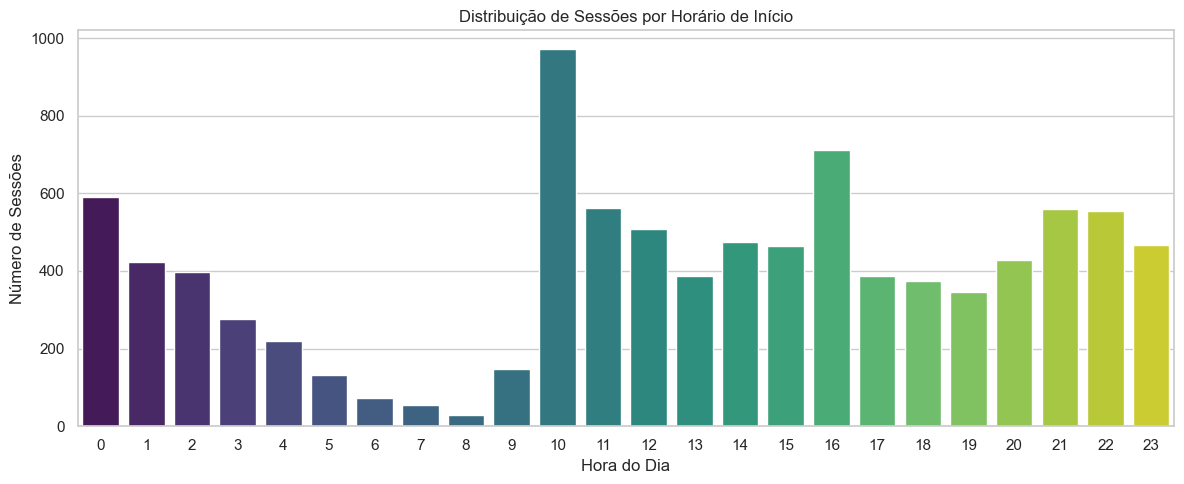

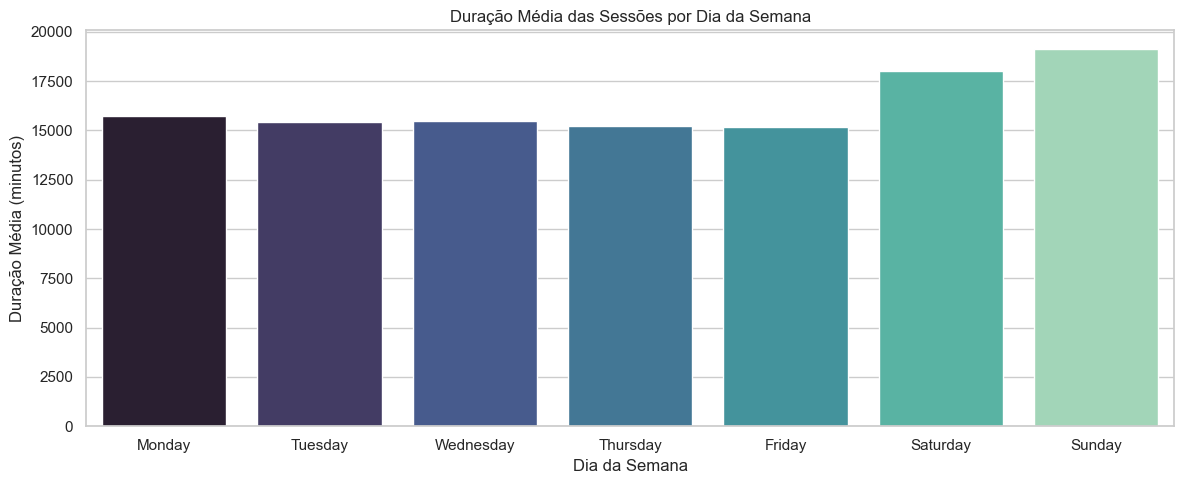

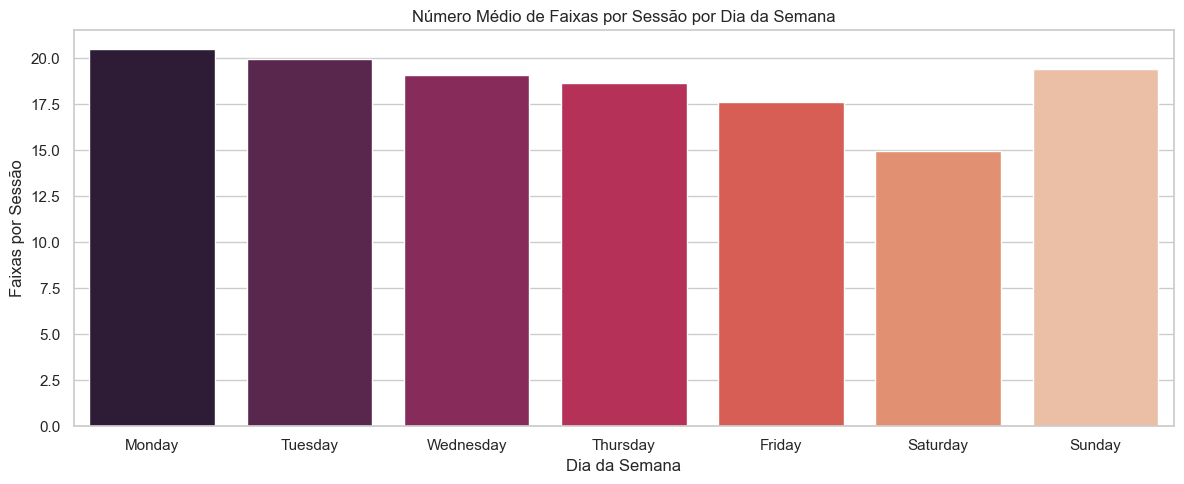

In [26]:
#Análise 12 — Sessões de Escuta por horário de início e dia da semana

#Identificar sessões de escuta com base em intervalos de tempo entre faixas e calcular métricas como duração média, número de faixas por sessão, e horários mais comuns de início.
# ## Sessões de Escuta
# Definindo sessões com base em intervalo de tempo entre faixas (ex: 30 minutos)

# Ordenar por timestamp
df_combined_sorted = df_combined.sort_values(by='ts').reset_index(drop=True)

# Calcular diferença de tempo entre faixas consecutivas
df_combined_sorted['ts_diff'] = df_combined_sorted['ts'].diff().dt.total_seconds().fillna(0)

# Definir nova sessão se diferença for maior que 30 minutos (1800 segundos)
df_combined_sorted['new_session'] = df_combined_sorted['ts_diff'] > 1800

# Criar ID de sessão incremental
df_combined_sorted['session_id'] = df_combined_sorted['new_session'].cumsum()

# Métricas por sessão
session_metrics = df_combined_sorted.groupby('session_id').agg(
    start_time=('ts', 'min'),
    end_time=('ts', 'max'),
    duration_minutes=('ts_diff', 'sum'),
    num_tracks=('ts', 'count'),
    total_play_time=('minutes_played', 'sum')
).reset_index()

# Adicionar hora de início para análise de horários
session_metrics['start_hour'] = session_metrics['start_time'].dt.hour
session_metrics['weekday'] = session_metrics['start_time'].dt.day_name()

# Visualizar sessões
session_metrics.head()

# ## Visualizações das Sessões de Escuta

# Estilo dos gráficos
sns.set(style="whitegrid")

# 1. Distribuição de sessões por horário de início
plt.figure(figsize=(12, 5))
sns.countplot(data=session_metrics, x='start_hour', palette='viridis')
plt.title('Distribuição de Sessões por Horário de Início')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Sessões')
plt.tight_layout()
plt.show()

# 2. Duração média das sessões por dia da semana
plt.figure(figsize=(12, 5))
avg_duration_by_weekday = session_metrics.groupby('weekday')['duration_minutes'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
sns.barplot(x=avg_duration_by_weekday.index, y=avg_duration_by_weekday.values, palette='mako')
plt.title('Duração Média das Sessões por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Duração Média (minutos)')
plt.tight_layout()
plt.show()

# 3. Número médio de faixas por sessão por dia da semana
plt.figure(figsize=(12, 5))
avg_tracks_by_weekday = session_metrics.groupby('weekday')['num_tracks'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
sns.barplot(x=avg_tracks_by_weekday.index, y=avg_tracks_by_weekday.values, palette='rocket')
plt.title('Número Médio de Faixas por Sessão por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Faixas por Sessão')
plt.tight_layout()
plt.show()



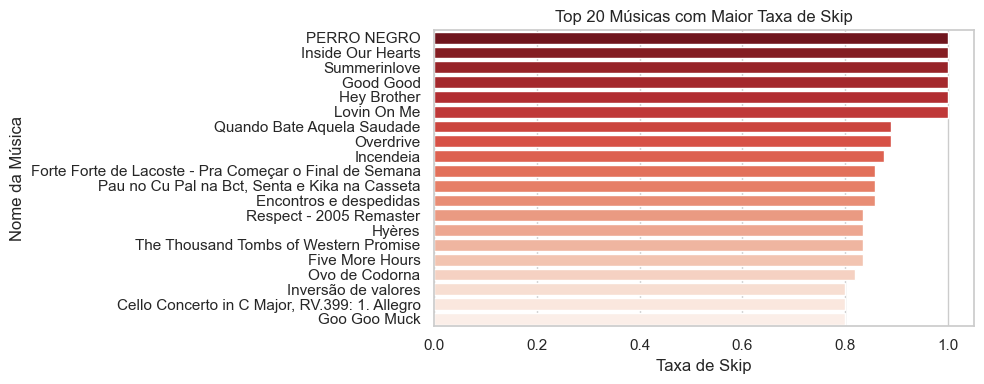

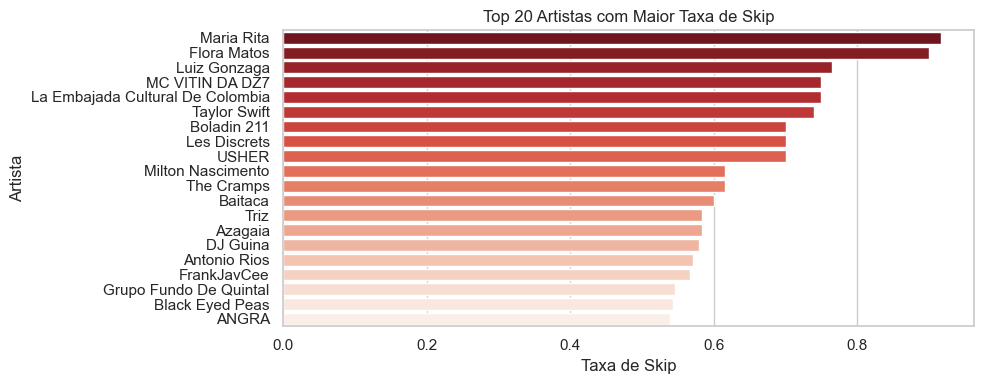

In [27]:
#Análise 13 — Taxa de Skip por Artista e Música

# quais conteúdos você tende a rejeitar mais, e podem ser úteis para filtragem de recomendações ou ajustes de playlists

# Agrupar por música
skip_by_track = df_combined.groupby('master_metadata_track_name').agg(
    total_plays=('skipped', 'count'),
    total_skips=('skipped', 'sum'),
    artist=('master_metadata_album_artist_name', 'first')
).reset_index()

# Calcular taxa de skip
skip_by_track['skip_rate'] = skip_by_track['total_skips'] / skip_by_track['total_plays']
skip_by_track = skip_by_track[skip_by_track['total_plays'] >= 5]  # filtrar músicas com pelo menos 5 reproduções

# Top 20 músicas com maior taxa de skip
top_skipped_tracks = skip_by_track.sort_values(by='skip_rate', ascending=False).head(20)

# Agrupar por artista
skip_by_artist = df_combined.groupby('master_metadata_album_artist_name').agg(
    total_plays=('skipped', 'count'),
    total_skips=('skipped', 'sum')
).reset_index()

# Calcular taxa de skip por artista
skip_by_artist['skip_rate'] = skip_by_artist['total_skips'] / skip_by_artist['total_plays']
skip_by_artist = skip_by_artist[skip_by_artist['total_plays'] >= 10]  # filtrar artistas com pelo menos 10 reproduções

# Top 20 artistas com maior taxa de skip
top_skipped_artists = skip_by_artist.sort_values(by='skip_rate', ascending=False).head(20)

# Visualizar
top_skipped_tracks[['master_metadata_track_name', 'artist', 'total_plays', 'total_skips', 'skip_rate']]

# ## Visualizações da Taxa de Skip

# %% [code]
# Gráfico de barras - Top 20 músicas com maior taxa de skip
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_skipped_tracks,
    x='skip_rate',
    y='master_metadata_track_name',
    palette='Reds_r'
)
plt.title('Top 20 Músicas com Maior Taxa de Skip')
plt.xlabel('Taxa de Skip')
plt.ylabel('Nome da Música')
plt.tight_layout()
plt.show()

# Gráfico de barras - Top 20 artistas com maior taxa de skip
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_skipped_artists,
    x='skip_rate',
    y='master_metadata_album_artist_name',
    palette='Reds_r'
)
plt.title('Top 20 Artistas com Maior Taxa de Skip')
plt.xlabel('Taxa de Skip')
plt.ylabel('Artista')
plt.tight_layout()
plt.show()


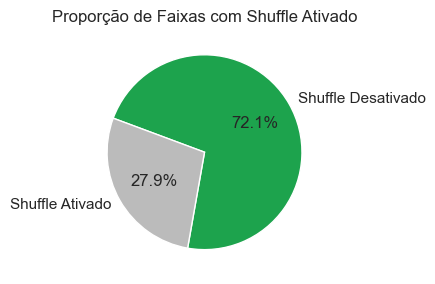

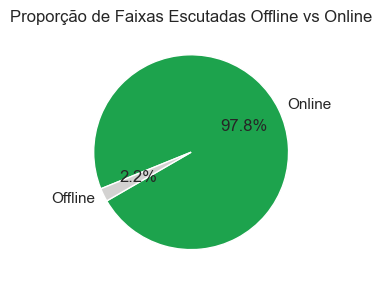

In [28]:
#Análise 14 — Uso de Shuffle e Escuta Offline

### Uso de Shuffle e Escuta Offline
#Analisar o comportamento de escuta com shuffle ativado e em modo offline, identificando padrões e proporções.

### Análise de Uso de Shuffle e Escuta Offline
## Shuffle: proporção de faixas tocadas com shuffle ativado
shuffle_stats = df_combined['shuffle'].value_counts(normalize=True).rename(index={True: 'Shuffle Ativado', False: 'Shuffle Desativado'}) * 100

## Offline: proporção de faixas tocadas offline
offline_stats = df_combined['offline'].value_counts(normalize=True).rename(index={True: 'Offline', False: 'Online'}) * 100

### Visualizações de Shuffle e Escuta Offline

# Gráfico de pizza - Shuffle
plt.figure(figsize=(4, 3))
shuffle_stats.plot.pie(autopct='%1.1f%%', colors=['#1da34d', "#bbbbbb"], startangle=260)
plt.title('Proporção de Faixas com Shuffle Ativado')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Gráfico de pizza - Offline
plt.figure(figsize=(4, 3))
offline_stats.plot.pie(autopct='%1.1f%%', colors=['#1da34d', "#d3d2d1"], startangle=210)
plt.title('Proporção de Faixas Escutadas Offline vs Online')
plt.ylabel('')
plt.tight_layout()
plt.show()


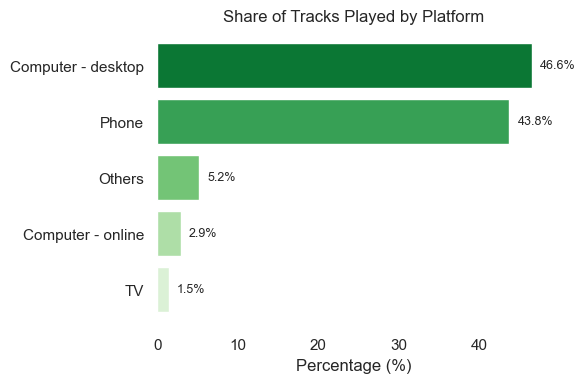

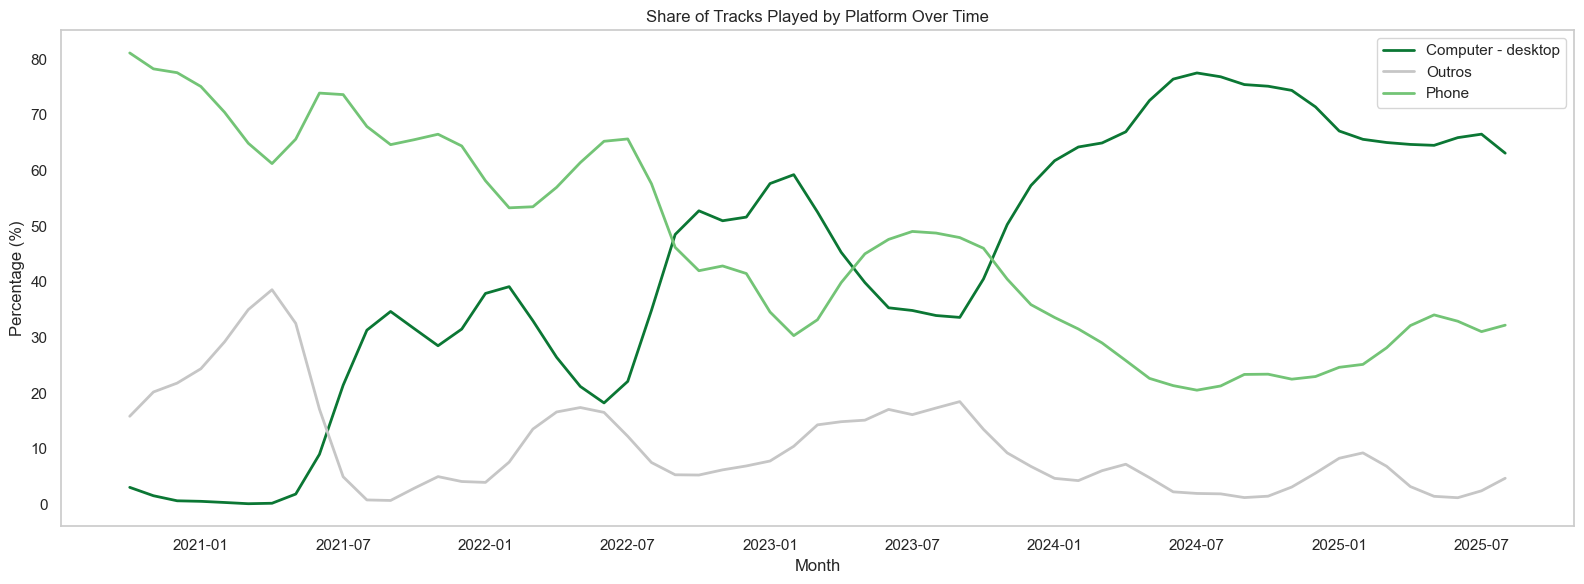

In [29]:
#Análise 15 — Análise por Plataforma - % utilizado e ao longo do tempo

por_plataforma = df_combined['platform_category'].value_counts(normalize=True) * 100

""" # 1º GRÁFICO: Proporção de faixas tocadas por plataforma
por_plataforma = df_combined['platform'].value_counts(normalize=True) * 100
por_plataforma = por_plataforma.sort_values(ascending=True)
colors = sns.color_palette("Greens", len(por_plataforma)) """


# 2º GRÁFICO: Proporção de faixas tocadas por plataforma
por_plataforma_categoria = df_combined['platform_category'].value_counts(normalize=True) * 100
por_plataforma_categoria = por_plataforma.sort_values(ascending=True)
colors = sns.color_palette("Greens", len(por_plataforma_categoria))

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.barh(por_plataforma_categoria.index, por_plataforma_categoria.values, color=colors)

# Remover bordas
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.grid(False)

# Adicionar os valores ao lado de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%', va='center', fontsize=9)

ax.set_title('Share of Tracks Played by Platform')
ax.set_xlabel('Percentage (%)')
plt.tight_layout()
plt.show()

# 3º GRÁFICO: Participação percentual das plataformas ao longo do tempo
# Parâmetro para controlar quais meses mostrar no eixo X
mostrar_meses_selecionados = True  # Altere para False se quiser mostrar todos os meses
# Gerar meses selecionados: janeiro e junho de 2020 a 2025
anos = range(2020, 2026)
meses_selecionados = [f'{ano}-01' for ano in anos] + [f'{ano}-07' for ano in anos]
# Contagem de faixas por mês e plataforma
contagem = df_combined.groupby(['year_month', 'platform_category']).size().reset_index(name='count')
# Total de faixas por mês
total_por_mes = contagem.groupby('year_month')['count'].sum().reset_index(name='total')
# Merge para calcular proporção
contagem = contagem.merge(total_por_mes, on='year_month')
contagem['percent'] = (contagem['count'] / contagem['total']) * 100
# Reclassificar plataformas como 'Outros'
contagem['platform_grouped'] = contagem['platform_category'].apply(
    lambda x: x if x in ['Computer - desktop', 'Phone'] else 'Outros'
)
# Reagrupar com nova classificação
contagem_grouped = contagem.groupby(['year_month', 'platform_grouped'])['percent'].sum().reset_index()
# Pivot para gráfico
pivot = contagem_grouped.pivot(index='year_month', columns='platform_grouped', values='percent')
pivot = pivot.sort_index()
# Suavização
pivot_smoothed = pivot.apply(lambda x: gaussian_filter1d(x.fillna(0), sigma=1), axis=0)
# Cores específicas
cores_por_plataforma = {
    'Computer - desktop': '#0b7734',
    'Phone': '#73c476',
    'Outros': '#c6c6c6'
}
# Plot
fig, ax = plt.subplots(figsize=(16, 6))
for column in pivot_smoothed.columns:
    ax.plot(pivot.index, pivot_smoothed[column], label=column, linewidth=2, color=cores_por_plataforma.get(column, '#000000'))
ax.set_title('Share of Tracks Played by Platform Over Time')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage (%)')
# Configurar os ticks do eixo X
if mostrar_meses_selecionados:
    ax.set_xticks([mes for mes in pivot.index if mes in meses_selecionados])
else:
    ax.set_xticks(pivot.index)
ax.tick_params(axis='x')#, rotation=45)
ax.grid(False)
ax.legend()
plt.tight_layout()
plt.show()


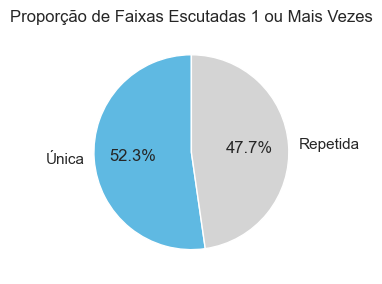

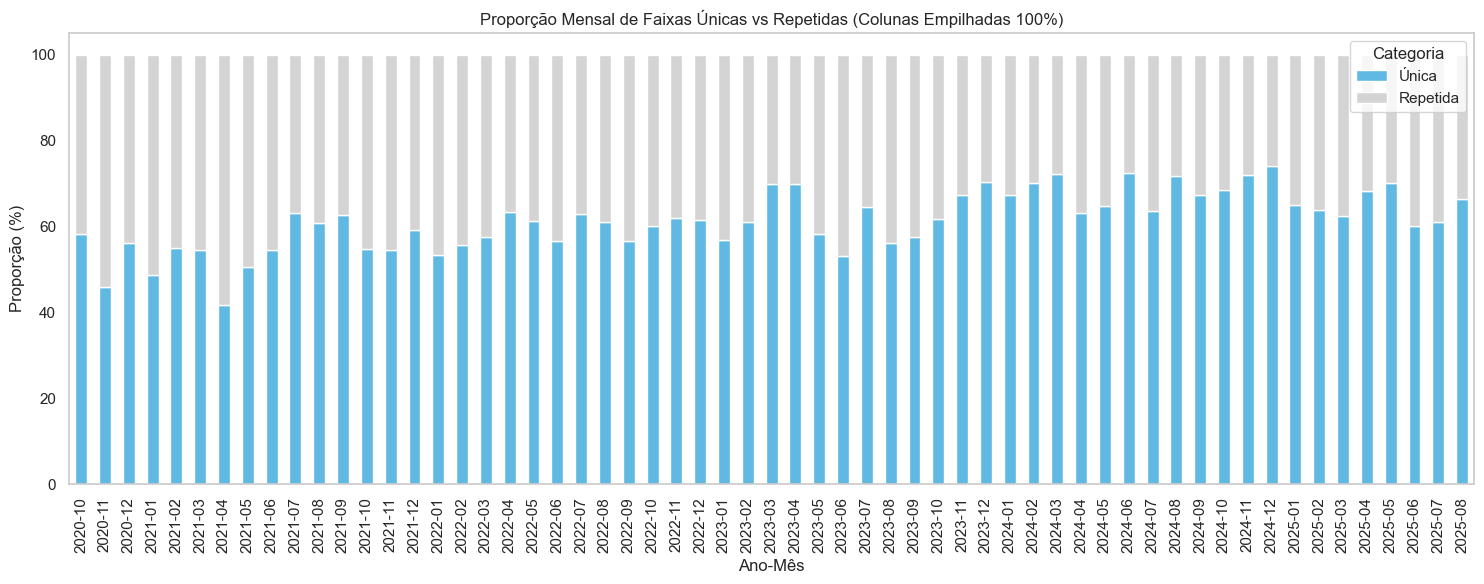

In [30]:
#Análise 16 — Faixas Escutadas Uma Única Vez vs Repetidas

## # Escutada mais de uma vez
# Proporção de faixas escutadas mais de uma vez
track_counts = df_combined['master_metadata_track_name'].value_counts()
repeat_stats = track_counts.apply(lambda x: 'Repetida' if x >= 2 else 'Única').value_counts(normalize=True) * 100

# Gráfico de pizza - Faixas únicas vs repetidas
plt.figure(figsize=(4, 3))
repeat_stats.plot.pie(autopct='%1.1f%%', colors=['#5fb9e2', '#d4d4d4'], startangle=90)
plt.title('Proporção de Faixas Escutadas 1 ou Mais Vezes')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Contar quantas vezes cada faixa foi tocada por mês
monthly_track_counts = df_combined.groupby(['year_month', 'master_metadata_track_name']).size().reset_index(name='play_count')

# Classificar cada faixa como 'Única' ou 'Repetida'
monthly_track_counts['categoria'] = monthly_track_counts['play_count'].apply(lambda x: 'Repetida' if x >= 2 else 'Única')

# Calcular proporções mensais
monthly_proportions = monthly_track_counts.groupby(['year_month', 'categoria']).size().unstack(fill_value=0)
monthly_proportions_percent = monthly_proportions.div(monthly_proportions.sum(axis=1), axis=0) * 100

# Reordenar para que 'Única' fique embaixo
# monthly_proportions = monthly_proportions[['Única', 'Repetida']]

# Reordenar para que 'Única' fique embaixo
monthly_proportions = monthly_proportions[['Única', 'Repetida']]

# Calcular proporções percentuais
monthly_proportions_percent = monthly_proportions.div(monthly_proportions.sum(axis=1),  axis=0) * 100

# Plotar gráfico de colunas empilhadas 100%
fig, ax = plt.subplots(figsize=(15, 6))
monthly_proportions_percent.plot(kind='bar', stacked=True, ax=ax, color=["#5fb9e2", "#d4d4d4"])

ax.set_title('Proporção Mensal de Faixas Únicas vs Repetidas (Colunas Empilhadas 100%)')
ax.set_xlabel('Ano-Mês')
ax.set_ylabel('Proporção (%)')
ax.legend(title='Categoria')
ax.grid(False)  # Remove o grid
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


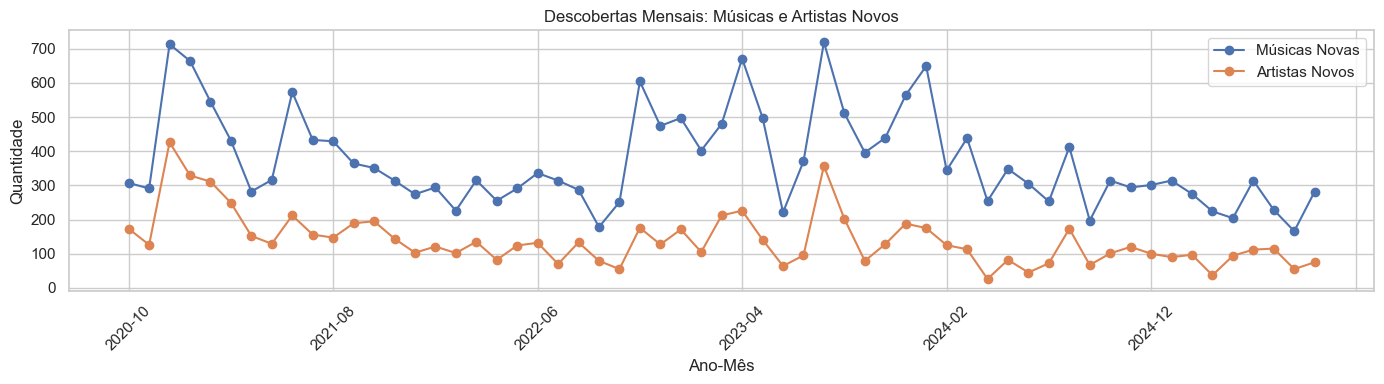

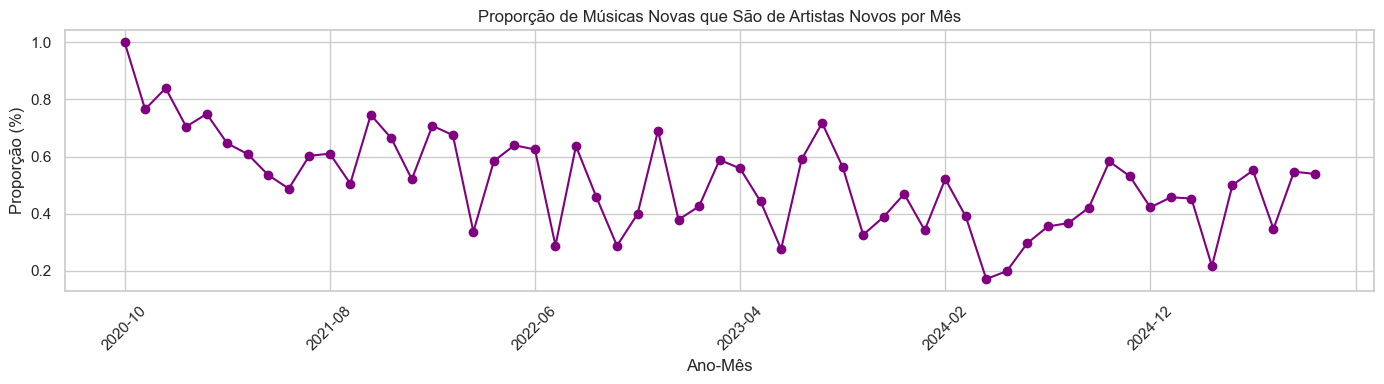

year_month
2020-10    1.000000
2020-11    0.765207
2020-12    0.839218
2021-01    0.704531
2021-02    0.749235
2021-03    0.646293
2021-04    0.608352
2021-05    0.535240
2021-06    0.487597
2021-07    0.602450
2021-08    0.609937
2021-09    0.505319
2021-10    0.745902
2021-11    0.663761
2021-12    0.520499
2022-01    0.707692
2022-02    0.674888
2022-03    0.336858
2022-04    0.584139
2022-05    0.639456
2022-06    0.624611
2022-07    0.288352
2022-08    0.636542
2022-09    0.457143
2022-10    0.287370
2022-11    0.398568
2022-12    0.690167
2023-01    0.378894
2023-02    0.425532
2023-03    0.588235
2023-04    0.558184
2023-05    0.442559
2023-06    0.275395
2023-07    0.589986
2023-08    0.717172
2023-09    0.563581
2023-10    0.325905
2023-11    0.388773
2023-12    0.469166
2024-01    0.341812
2024-02    0.521222
2024-03    0.390213
2024-04    0.171220
2024-05    0.198773
2024-06    0.296451
2024-07    0.355014
2024-08    0.366920
2024-09    0.420779
2024-10    0.582687
2024-11  

In [31]:
#Análise  17 — Identificação de Músicas e Artistas Novos

# Identificar o primeiro mês em que cada música e artista foram tocados
df_combined['first_month_track'] = df_combined.groupby('master_metadata_track_name')['year_month'].transform('min')
df_combined['first_month_artist'] = df_combined.groupby('master_metadata_album_artist_name')['year_month'].transform('min')

# Filtrar músicas novas por mês
new_tracks = df_combined[df_combined['year_month'] == df_combined['first_month_track']].copy()
new_tracks['artista_novo'] = new_tracks['year_month'] == new_tracks['first_month_artist']

# Contar músicas novas e artistas novos por mês
new_tracks_per_month = new_tracks.groupby('year_month')['master_metadata_track_name'].nunique()
new_artists_per_month = df_combined[df_combined['year_month'] == df_combined['first_month_artist']] \
    .groupby('year_month')['master_metadata_album_artist_name'].nunique()

# Proporção de músicas novas que são de artistas novos
proporcao_novas_de_artistas_novos = new_tracks.groupby('year_month')['artista_novo'].mean()

# Gráfico 1: Quantidade de músicas e artistas novos
pd.DataFrame({
    'Músicas Novas': new_tracks_per_month,
    'Artistas Novos': new_artists_per_month
}).plot(figsize=(14, 4), marker='o', title='Descobertas Mensais: Músicas e Artistas Novos')
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Proporção de músicas novas que são de artistas novos
proporcao_novas_de_artistas_novos.plot(figsize=(14, 4), marker='o', color='purple',
                                       title='Proporção de Músicas Novas que São de Artistas Novos por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

proporcao_novas_de_artistas_novos

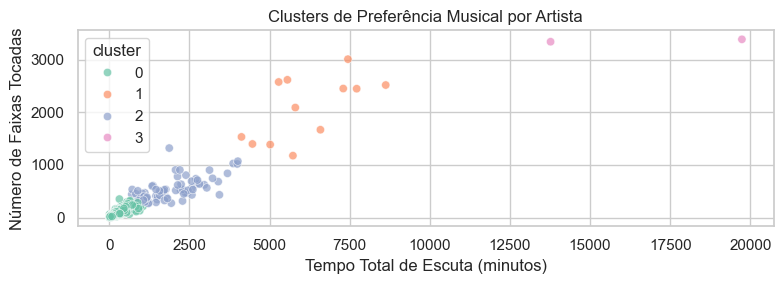

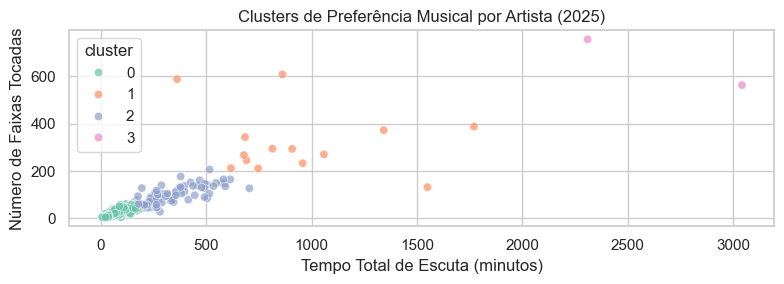

In [32]:
#Análise 18 - Análise de Cluster

# Função genérica para clusterizar e visualizar
def clusterizar_artistas(df, titulo="Clusters de Preferência Musical por Artista", n_clusters=4):
    # Agrupar por artista
    artist_features = df.groupby('master_metadata_album_artist_name').agg(
        total_minutes=('minutes_played', 'sum'),
        total_tracks=('master_metadata_track_name', 'count')
    ).reset_index()

    # Remover artistas com poucos dados
    artist_features = artist_features[artist_features['total_tracks'] >= 5]

    # Normalizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(artist_features[['total_minutes', 'total_tracks']])

    # Aplicar KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    artist_features['cluster'] = kmeans.fit_predict(X_scaled)

    # Visualizar os clusters
    plt.figure(figsize=(8, 3))
    sns.scatterplot(
        data=artist_features,
        x='total_minutes',
        y='total_tracks',
        hue='cluster',
        palette='Set2',
        alpha=0.7
    )
    plt.title(titulo)
    plt.xlabel('Tempo Total de Escuta (minutos)')
    plt.ylabel('Número de Faixas Tocadas')
    plt.tight_layout()
    plt.show()

    return artist_features

# ---- Uso da função ----

# Clusterização geral
clusters_geral = clusterizar_artistas(df_combined, titulo="Clusters de Preferência Musical por Artista")

# Clusterização apenas para 2025
df_2025 = df_combined[df_combined['year'] == 2025]
clusters_2025 = clusterizar_artistas(df_2025, titulo="Clusters de Preferência Musical por Artista (2025)")


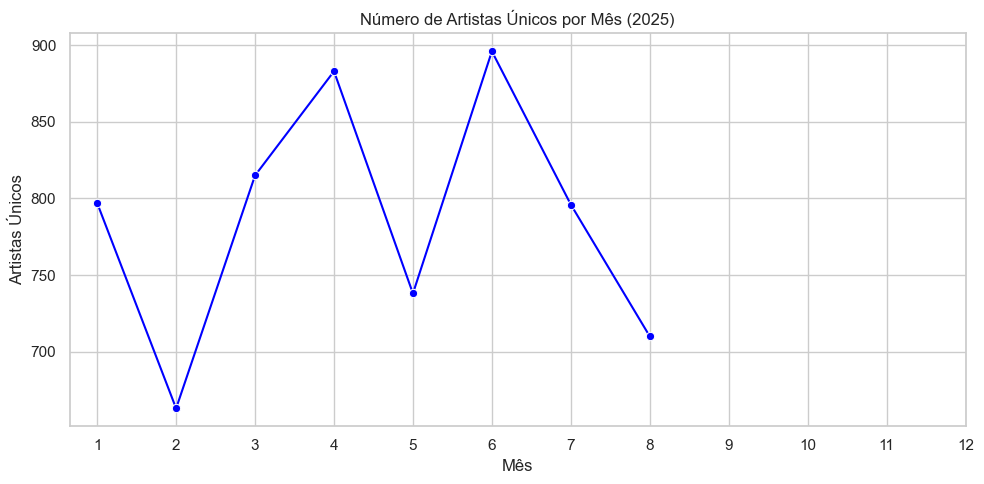

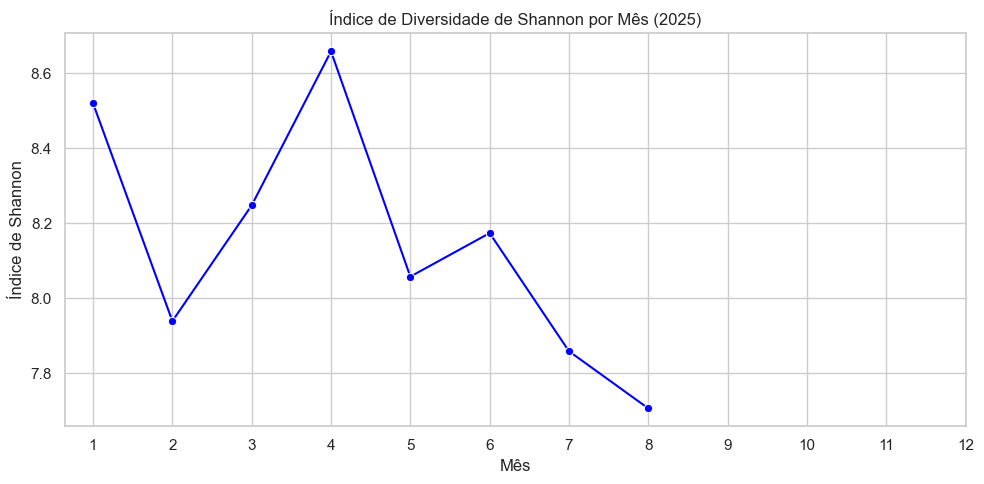

In [33]:
# Análise 19 - Diversidade Musical (2025)
# O Índice de Diversidade de Shannon (ou Shannon Entropy) é uma métrica usada para quantificar a diversidade em uma distribuição, muito comum em ecologia, mas também útil em análise de comportamento, como no seu caso com músicas e artistas.

""" O índice mede quão distribuída está a atenção (ou escuta) entre diferentes categorias — no seu caso, artistas. Ele considera quantos artistas diferentes você escutou e quão equilibrado foi o tempo de escuta entre eles.
Se você escutou muitos artistas com tempos semelhantes, o índice será alto.
Se você escutou poucos artistas ou concentrou muito tempo em um só, o índice será baixo. 
## 📘 Como é calculado o Índice de Diversidade de Shannon

O Índice de Shannon (H) é calculado da seguinte forma:

**H = negativo do somatório**, de \( i = 1 \) até \( n \), da **proporção de escuta do artista \( i \)** em relação ao total de escutas do mês, **multiplicada pelo logaritmo de base 2 dessa mesma proporção**.

Ou seja:

- Para cada artista \( i \), calcula-se \( p_i \), que é a proporção de escuta (tempo ou número de faixas) desse artista em relação ao total do mês.
- Em seguida, calcula-se \( p_i \cdot \log_2(p_i) \).
- Soma-se esse valor para todos os artistas do mês.
- O índice final é o **negativo dessa soma**.

Esse índice mede **quão distribuída** está sua escuta entre os artistas:
- Quanto mais equilibrada a distribuição, **maior o índice**.
- Quanto mais concentrada em poucos artistas, **menor o índice**.

FORMULA

- **Índice próximo de 0**: escuta concentrada em poucos artistas.
- **Índice médio (~1–2)**: escuta moderadamente distribuída.
- **Índice alto (>2)**: escuta bem distribuída entre muitos artistas.
 """

#Diversidade Musical por Mês (2025)

# Filtrar dados de 2025
df_2025 = df_combined[df_combined['year'] == 2025]

# Agrupar por mês e artista
monthly_artist_counts = df_2025.groupby(['month', 'master_metadata_album_artist_name']).size().reset_index(name='play_count')

# Número de artistas únicos por mês
unique_artists_per_month = monthly_artist_counts.groupby('month')['master_metadata_album_artist_name'].nunique()

# Índice de Shannon por mês
def shannon_entropy(group):
    proportions = group['play_count'] / group['play_count'].sum()
    return -np.sum(proportions * np.log2(proportions))

shannon_by_month = monthly_artist_counts.groupby('month').apply(shannon_entropy)

# Criar DataFrame para visualização
diversity_df = pd.DataFrame({
    'unique_artists': unique_artists_per_month,
    'shannon_index': shannon_by_month
}).reset_index()

diversity_df

# ## Visualização da Diversidade Musical (2025)

# Gráfico de artistas únicos por mês
plt.figure(figsize=(10, 5))
sns.lineplot(data=diversity_df, x='month', y='unique_artists', marker='o', color='blue')
plt.title('Número de Artistas Únicos por Mês (2025)')
plt.xlabel('Mês')
plt.ylabel('Artistas Únicos')
plt.xticks(range(1, 13))
plt.tight_layout()


# Gráfico do índice de Shannon por mês
plt.figure(figsize=(10, 5))
sns.lineplot(data=diversity_df, x='month', y='shannon_index', marker='o', color='blue')
plt.title('Índice de Diversidade de Shannon por Mês (2025)')
plt.xlabel('Mês')
plt.ylabel('Índice de Shannon')
plt.xticks(range(1, 13))
plt.tight_layout()



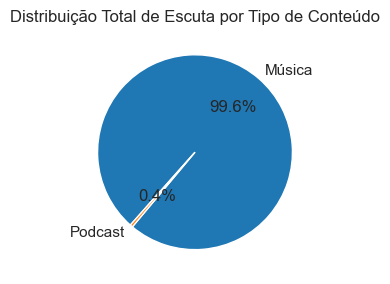

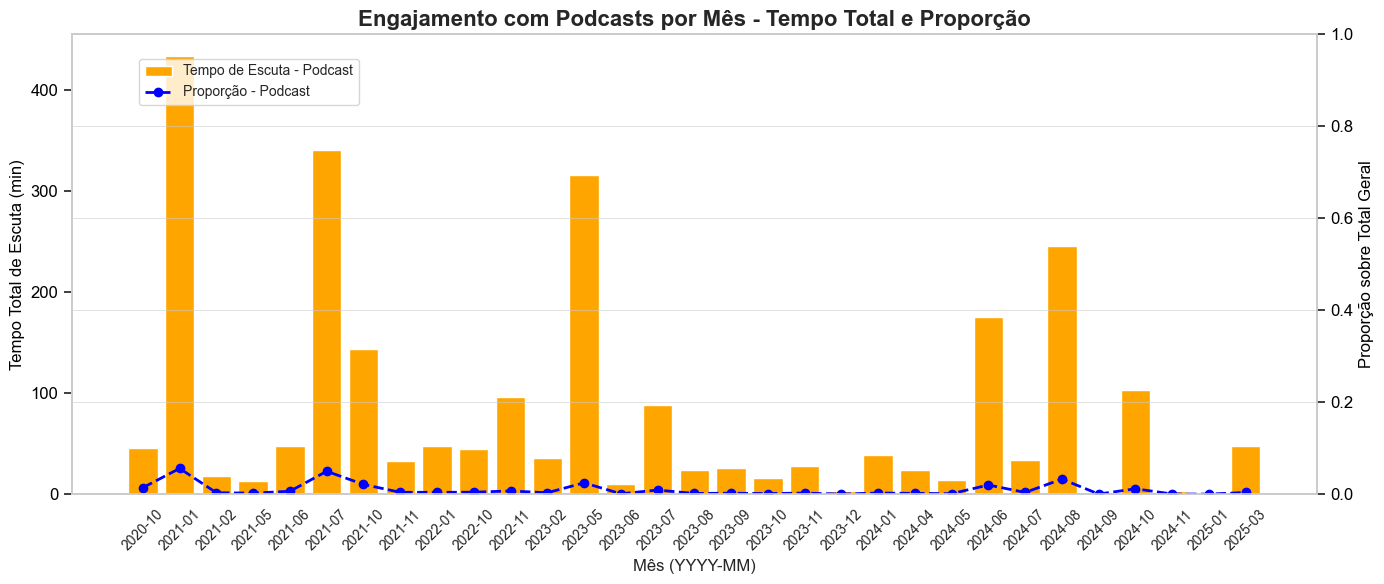

year_month  minutes_played_podcast  minutes_played_geral  proporcao
0     2020-10               46.061000           3228.354150   0.014268
1     2021-01              433.778367           7743.586300   0.056018
2     2021-02               18.336983           5782.365750   0.003171
3     2021-05               13.082350           5534.272017   0.002364
4     2021-06               48.110983           7476.593117   0.006435
5     2021-07              340.846533           6842.210700   0.049815
6     2021-10              143.573467           6739.368267   0.021304
7     2021-11               32.624333           8016.328733   0.004070
8     2022-01               47.850333          11646.048217   0.004109
9     2022-10               45.129000          10395.858550   0.004341
10    2022-11               95.989833          13571.436483   0.007073
11    2023-02               36.179733          11496.916083   0.003147
12    2023-05              316.602083          12802.290633   0.024730
13    2023-06               10.076300          10311.547633   0.000977
14    2023-07               88.858767           9869.804700   0.009003
15    2023-08               23.849117          14633.116983   0.001630
16    2023-09               26.242167          11909.732000   0.002203
17    2023-10               16.036350          11555.533050   0.001388
18    2023-11               27.607350          11426.476633   0.002416
19    2023-12                3.426933          13211.212067   0.000259
20    2024-01               38.892300          15210.756083   0.002557
21    2024-04               24.039533          13080.224783   0.001838
22    2024-05               14.245333          12794.005433   0.001113
23    2024-06              175.263817           8768.029417   0.019989
24    2024-07               34.166067           8892.777917   0.003842
25    2024-08              246.254117           7503.342383   0.032819
26    2024-09                2.390767           7173.960883   0.000333
27    2024-10              103.682150           8807.047450   0.011773
28    2024-11                2.986700           6979.672583   0.000428
29    2025-01                1.670200           8942.957283   0.000187
30    2025-03               47.798433          12622.414833   0.003787

In [34]:
#Análise  20 — Engajamento com Podcasts: Tempo Total e Proporção Mensal

# Gráfico de pizza — distribuição total por tipo de conteúdo
conteudo_total = df_combined.groupby('tipo_conteudo')['minutes_played'].sum()
plt.figure(figsize=(4, 3))
conteudo_total.plot.pie(
    autopct='%1.1f%%',
    startangle=230,
    colors=['#1f77b4', '#ff7f0e', '#2ca02c']
)
plt.title('Distribuição Total de Escuta por Tipo de Conteúdo')
plt.ylabel('')
plt.tight_layout()


# Criar coluna de ano/mês no formato 'YYYY-MM'
df_combined['year_month'] = df_combined['ts'].dt.strftime('%Y-%m')

# Tempo total de escuta de podcasts por mês (apenas meses com escuta > 1)
podcast_por_mes = df_combined[df_combined['tipo_conteudo'] == 'Podcast'] \
    .groupby('year_month')['minutes_played'].sum().reset_index()
podcast_por_mes = podcast_por_mes[podcast_por_mes['minutes_played'] > 1]

# Total geral por mês
total_geral_por_mes = df_combined.groupby('year_month')['minutes_played'].sum().reset_index()

# Merge e cálculo de proporção
podcast_merged = pd.merge(podcast_por_mes, total_geral_por_mes, on='year_month', suffixes=('_podcast', '_geral'))
podcast_merged['proporcao'] = podcast_merged['minutes_played_podcast'] / podcast_merged['minutes_played_geral']

# Gráfico combinado — barras para tempo total e linha para proporção
fig, ax1 = plt.subplots(figsize=(14, 6))

# Gráfico de barras — tempo total de escuta de podcasts
ax1.bar(
    podcast_merged['year_month'],
    podcast_merged['minutes_played_podcast'],
    color='orange',
    label='Tempo de Escuta - Podcast'
)
ax1.set_xlabel('Mês (YYYY-MM)', fontsize=12)
ax1.set_ylabel('Tempo Total de Escuta (min)', fontsize=12, color='black')
ax1.tick_params(axis='x', labelsize=10, rotation=45)
ax1.tick_params(axis='y', labelsize=12, labelcolor='black')
ax1.grid(False)


# Eixo secundário — proporção
ax2 = ax1.twinx()
ax2.plot(
    podcast_merged['year_month'],
    podcast_merged['proporcao'],
    color='blue',
    linewidth=2,
    marker='o',
    linestyle='--',
    label='Proporção - Podcast'
)
ax2.set_ylabel('Proporção sobre Total Geral', fontsize=12, color='black')
ax2.tick_params(axis='y', labelsize=12, labelcolor='black')
ax2.set_ylim(0, 1)
ax2.grid(True, linewidth=0.4)

# Título e legenda
plt.title('Engajamento com Podcasts por Mês - Tempo Total e Proporção', fontsize=16, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=10)
plt.tight_layout()
plt.show()

podcast_merged


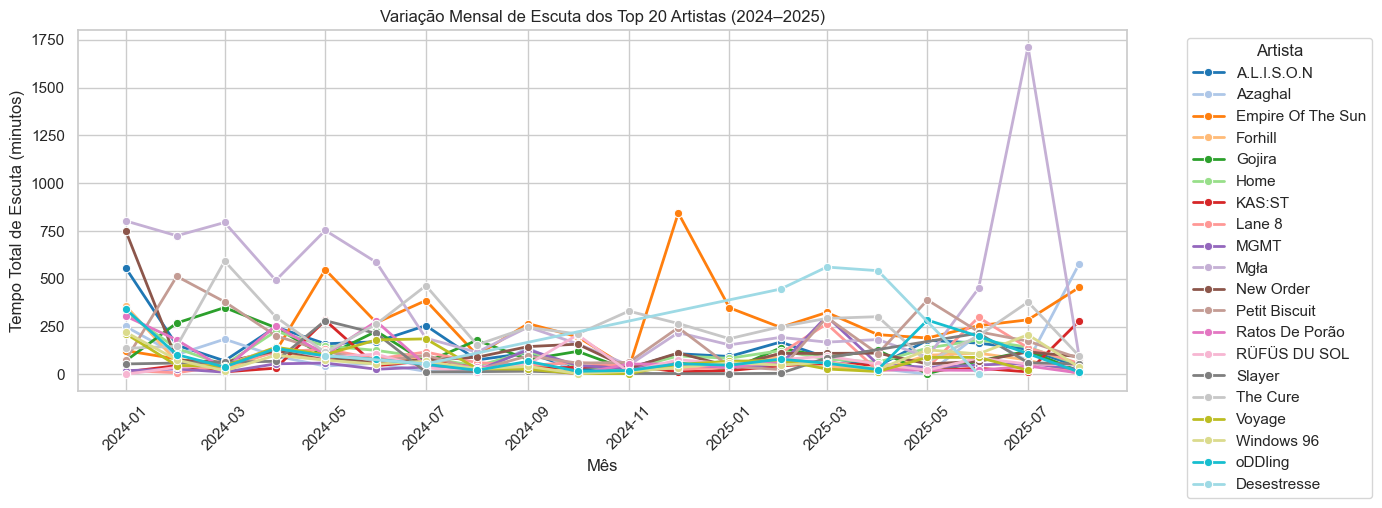

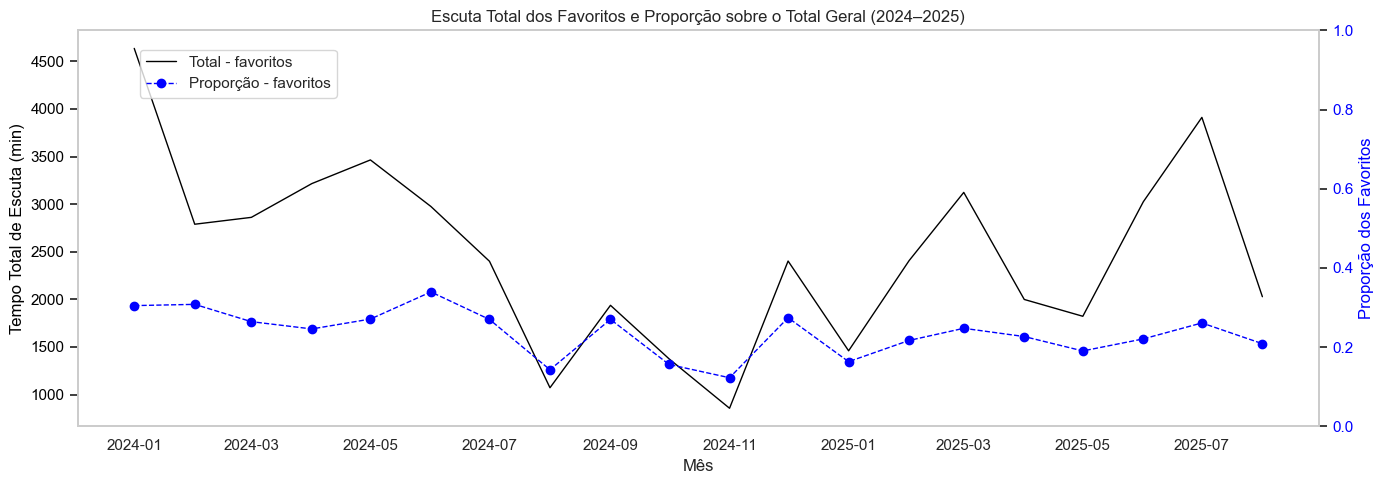

year_month  total_minutes  minutes_played  proporcao
0  2024-01-01    4635.744867    15210.756083   0.304768
1  2024-02-01    2788.704617     9056.100817   0.307937
2  2024-03-01    2860.878800    10828.350817   0.264203
3  2024-04-01    3215.698250    13080.224783   0.245844
4  2024-05-01    3464.179233    12794.005433   0.270766
5  2024-06-01    2975.095333     8768.029417   0.339312
6  2024-07-01    2399.667817     8892.777917   0.269845
7  2024-08-01    1071.108633     7503.342383   0.142751
8  2024-09-01    1936.935117     7173.960883   0.269995
9  2024-10-01    1375.017350     8807.047450   0.156127
10 2024-11-01     855.506250     6979.672583   0.122571
11 2024-12-01    2402.107433     8760.404067   0.274201
12 2025-01-01    1459.122567     8942.957283   0.163159
13 2025-02-01    2406.453733    11100.326483   0.216791
14 2025-03-01    3123.035017    12622.414833   0.247420
15 2025-04-01    1998.436033     8818.705033   0.226613
16 2025-05-01    1821.746000     9575.557917   0.190250
17 2025-06-01    3024.981767    13707.612717   0.220679
18 2025-07-01    3911.252167    14987.542267   0.260967
19 2025-08-01    2027.494850     9720.969300   0.208569

In [35]:
#Análise 21 — Mudança de Preferências Musicais e Concentração de favoritos ao Longo do Tempo

# Filtrar apenas os anos desejados
df_filtrado = df_combined[df_combined['year'].isin([2024, 2025])]

# Criar coluna de ano-mês como datetime
df_filtrado['year_month'] = pd.to_datetime(df_filtrado['ts']).dt.to_period('M').dt.to_timestamp()

# Agrupar por artista e somar minutos
top_artistas = df_filtrado.groupby('master_metadata_album_artist_name')['minutes_played'].sum().reset_index()

# Selecionar os 20 mais escutados
top_20_artistas = top_artistas.sort_values(by='minutes_played', ascending=False).head(20)

# Filtrar o DataFrame original para conter apenas os top 20
df_top_20 = df_filtrado[df_filtrado['master_metadata_album_artist_name'].isin(top_20_artistas['master_metadata_album_artist_name'])]

# Agrupar por artista e mês
monthly_top_20 = df_top_20.groupby(['year_month', 'master_metadata_album_artist_name'])['minutes_played'].sum().reset_index()
monthly_top_20.rename(columns={'minutes_played': 'total_minutes'}, inplace=True)

# Gráfico 1: escuta por artista
plt.figure(figsize=(14, 5))
sns.lineplot(
    data=monthly_top_20,
    x='year_month',
    y='total_minutes',
    hue='master_metadata_album_artist_name',
    marker='o',
    palette='tab20',
    linewidth=2
)
plt.title('Variação Mensal de Escuta dos Top 20 Artistas (2024–2025)')
plt.xlabel('Mês')
plt.ylabel('Tempo Total de Escuta (minutos)')
plt.xticks(rotation=45)
plt.legend(title='Artista', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(False)
plt.tight_layout()
plt.show()

# Calcular total geral de escuta por mês
total_geral_por_mes = df_filtrado.groupby('year_month')['minutes_played'].sum().reset_index()

# Calcular total dos favoritos por mês
total_favoritos_por_mes = monthly_top_20.groupby('year_month')['total_minutes'].sum().reset_index()

# Juntar os dois DataFrames
proporcao_df = pd.merge(
    total_favoritos_por_mes,
    total_geral_por_mes,
    on='year_month'
)

# Calcular proporção
proporcao_df['proporcao'] = proporcao_df['total_minutes'] / proporcao_df['minutes_played']


# Gráfico com dois eixos
fig, ax1 = plt.subplots(figsize=(14, 5))

# Eixo primário: total de minutos dos favoritos
ax1.plot(
    proporcao_df['year_month'],
    proporcao_df['total_minutes'],
    color='black',
    linewidth=1,
    label='Total - favoritos'
)
ax1.set_xlabel('Mês')
ax1.set_ylabel('Tempo Total de Escuta (min)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
#ax1.grid(True, linewidth=0.4)

# Eixo secundário: proporção
ax2 = ax1.twinx()
ax2.plot(
    proporcao_df['year_month'],
    proporcao_df['proporcao'],
    color='blue',
    linewidth=1,
    marker='o',
    linestyle='--',
    label='Proporção - favoritos'
)
ax2.set_ylabel('Proporção dos Favoritos', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)
ax2.grid(False)

# Título e layout
plt.title('Escuta Total dos Favoritos e Proporção sobre o Total Geral (2024–2025)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.show()


# Exibir tabela com proporções
proporcao_df[['year_month', 'total_minutes', 'minutes_played', 'proporcao']]


In [36]:
#Análise 22 - Retenção e Frequência de Uso
# Criar função para calcular métricas de retenção por pessoa
# Garantindo que estamos usando apenas a data (sem hora/minuto/segundo)
df_combined['date_only'] = pd.to_datetime(df_combined['ts']).dt.date

# Função para calcular métricas de retenção por pessoa
def calcular_retencao_por_pessoa(df):
    resultados = []

    for pessoa, group in df.groupby('pessoa'):
        # Ordenar dias únicos corretamente
        unique_days = sorted(group['date_only'].drop_duplicates())
        
        # Calcular gaps de uso (>1 dia)
        gaps = [(unique_days[i] - unique_days[i-1]).days 
                for i in range(1, len(unique_days)) if (unique_days[i] - unique_days[i-1]).days > 1]
        
        # Calcular streaks (dias consecutivos)
        consecutive_days = []
        streak = 1
        for i in range(1, len(unique_days)):
            if (unique_days[i] - unique_days[i-1]).days == 1:
                streak += 1
            else:
                consecutive_days.append(streak)
                streak = 1
        consecutive_days.append(streak)
        
        # Estatísticas
        total_dias_unicos = len(unique_days)
        numero_gaps = len(gaps)
        media_gaps = sum(gaps)/len(gaps) if gaps else 0
        maior_streak = max(consecutive_days) if consecutive_days else 0
        
        resultados.append({
            "pessoa": pessoa,
            "total_dias_unicos": total_dias_unicos,
            "numero_gaps": numero_gaps,
            "media_gaps": round(media_gaps, 2),
            "maior_streak_consecutivo": maior_streak
        })
    
    return resultados

# Aplicar a função
retencao_por_pessoa = calcular_retencao_por_pessoa(df_combined)

# Visualizar resultado
retencao_por_pessoa

[{'pessoa': 'tomas',
  'total_dias_unicos': 1787,
  'numero_gaps': 0,
  'media_gaps': 0,
  'maior_streak_consecutivo': 1787}]

In [37]:
#Análise 23 - Classificação de Músicas por Probabilidade de Serem Ouvidas Novamente (Random Forest)

""" O que cada métrica significa?
Precision: Proporção de previsões corretas entre todas as previsões feitas para aquela classe.

Classe 0: Apenas 18% das previsões de "não ouvida novamente" estavam corretas.
Classe 1: 93% das previsões de "ouvida novamente" estavam corretas.
Recall: Proporção de acertos entre todos os exemplos reais daquela classe.

Classe 0: O modelo só identificou corretamente 12% dos casos reais de "não ouvida novamente".
Classe 1: O modelo identificou corretamente 96% dos casos reais de "ouvida novamente".
F1-score: Média harmônica entre precision e recall. É útil quando há desequilíbrio entre classes, como é o seu caso.

Support: Quantidade de exemplos reais de cada classe no conjunto de teste.

Problema Identificado: Desequilíbrio de Classes
Você tem muito mais exemplos da classe 1 (ouvida novamente) do que da classe 0. Isso faz com que o modelo aprenda a priorizar a classe majoritária, ignorando a minoritária.
Acurácia geral: 90%
Apesar de parecer boa, essa acurácia é enganosa porque o modelo está acertando principalmente os casos da classe 1. Ele praticamente ignora a classe 0. """

# Criar variável alvo: se a música foi ouvida mais de uma vez
df_combined['listened_again'] = df_combined.duplicated(subset=['master_metadata_track_name', 'master_metadata_album_artist_name'], keep=False).astype(int)

# Selecionar features
features = ['seconds_played', 'skipped', 'shuffle', 'time', 'platform_category', 'reason_start', 'reason_end', 'tipo_conteudo']
X = df_combined[features].copy()
y = df_combined['listened_again']

# Codificar variáveis categóricas
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Treinar modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.18      0.12      0.15      2553
           1       0.93      0.96      0.94     33048

    accuracy                           0.90     35601
   macro avg       0.56      0.54      0.55     35601
weighted avg       0.88      0.90      0.89     35601



In [38]:
# ============================================================
# ETL - GET ARTISTS STYLE
# ============================================================

# Criar df com valores distintos de genres, removendo nulos e espaços
df_genres = (
    df_combined['genres']
    .dropna()                   # remove valores nulos (NaN)
    .map(str.strip)             # remove espaços em branco no início/fim
    .loc[lambda x: x != ""]    # remove strings vazias
    .drop_duplicates()          # remove duplicados
    .sort_values()              # ordena os valores alfabeticamente
    .to_frame(name='genres')    # transforma em DataFrame e nomeia a coluna
)

# Exportar para Excel
df_genres.to_excel("df_genres.xlsx", index=False)

# Caminho do arquivo Excel gerado anteriormente
arquivo_excel = r"C:\Users\tomas\OneDrive\Documentos\project_python_pipeline_tomas_spotify\df_genres_estilo_regras.xlsx"

# Ler o Excel e filtrar colunas 
df_estilos = pd.read_excel(arquivo_excel)
df_estilos = df_estilos[['genres', 'estilo', 'primary_style']]
# Conferir resultado
df_estilos

genres      estilo  \
0                                                3 step      3 step   
1               acid house, acid techno, breakbeat, idm  acid house   
2                                 acid house, breakbeat  acid house   
3        acid house, chicago house, techno, acid techno  acid house   
4               acid house, idm, techno, minimal techno  acid house   
...                                                 ...         ...   
2635                      yacht rock, aor, classic rock  yacht rock   
2636                           yacht rock, classic rock  yacht rock   
2637  yacht rock, classic rock, soft rock, southern ...  yacht rock   
2638                              yacht rock, soft rock  yacht rock   
2639                   yacht rock, soft rock, folk rock  yacht rock   

     primary_style  
0       Electronic  
1            House  
2            House  
3            House  
4            House  
...            ...  
2635          Rock  
2636          Rock  
2637          Rock  
2638          Rock  
2639          Rock  

[2640 rows x 3 columns]

In [39]:
# Merge do df_combined com df_estilos para trazer a coluna 'estilo'
df_combined = df_combined.merge(
    df_estilos[['genres', 'estilo', 'primary_style']],  # seleciona apenas as colunas necessárias
    on='genres',                        # chave de junção
    how='left'                           # mantém todas as linhas de df_combined
)

df_combined


ts                                 platform  \
0      2020-10-01 04:27:22  Android OS 9 API 28 (samsung, SM-A530F)   
1      2020-10-01 04:29:43  Android OS 9 API 28 (samsung, SM-A530F)   
2      2020-10-01 12:27:35  Android OS 9 API 28 (samsung, SM-A530F)   
3      2020-10-01 12:31:24  Android OS 9 API 28 (samsung, SM-A530F)   
4      2020-10-01 12:33:46  Android OS 9 API 28 (samsung, SM-A530F)   
...                    ...                                      ...   
177998 2025-08-18 21:48:40                           not_applicable   
177999 2025-08-18 22:14:54                           not_applicable   
178000 2025-08-18 22:19:19                           not_applicable   
178001 2025-08-20 20:47:21                                  android   
178002 2025-08-22 04:07:10                                  android   

        ms_played master_metadata_track_name  \
0               0                   Red Drop   
1          141394        Судно (Борис Рижий)   
2          294605                   A Forest   
3          211488                   Red Drop   
4          141394        Судно (Борис Рижий)   
...           ...                        ...   
177998     311540          We Are The People   
177999     213440                Without You   
178000       1044                Without You   
178001       1295              Factory Gates   
178002          0         Eyes Of The Insane   

       master_metadata_album_artist_name master_metadata_album_album_name  \
0                               Motorama                          Poverty   
1                           Molchat Doma                            Этажи   
2                               The Cure                Seventeen Seconds   
3                               Motorama                          Poverty   
4                           Molchat Doma                            Этажи   
...                                  ...                              ...   
177998                 Empire Of The Sun                We Are The People   
177999                 Empire Of The Sun                      Without You   
178000                 Empire Of The Sun                      Without You   
178001                            Sun Lo                    Factory Gates   
178002                            Slayer               Eyes Of The Insane   

                           spotify_track_uri reason_start reason_end  shuffle  \
0       spotify:track:0jyOu6GTwQ3c0hVXYwGZpL     clickrow    endplay    False   
1       spotify:track:6DONTnamNDOJdO6DzCu71p     clickrow  trackdone    False   
2       spotify:track:4iVTSRiJAA18d3QglhyJ6Q    trackdone     logout    False   
3       spotify:track:0jyOu6GTwQ3c0hVXYwGZpL     clickrow  trackdone    False   
4       spotify:track:6DONTnamNDOJdO6DzCu71p    trackdone  trackdone    False   
...                                      ...          ...        ...      ...   
177998  spotify:track:4MOfbx2sjc3TkVOfDTUVXQ    trackdone  trackdone    False   
177999  spotify:track:2BGGFA21PFrXRdRQrD2ebO    trackdone  trackdone    False   
178000  spotify:track:2BGGFA21PFrXRdRQrD2ebO       fwdbtn    endplay    False   
178001  spotify:track:5U2ie4GmqqPND07h3HINkI      unknown    endplay    False   
178002  spotify:track:04UxuiwkTrv5mwuRHsLr2S      unknown    endplay    False   

        ...        artist_name  \
0       ...           Motorama   
1       ...       Molchat Doma   
2       ...           The Cure   
3       ...           Motorama   
4       ...       Molchat Doma   
...     ...                ...   
177998  ...  Empire Of The Sun   
177999  ...  Empire Of The Sun   
178000  ...  Empire Of The Sun   
178001  ...             Sun Lo   
178002  ...             Slayer   

                                                   genres popularity day  \
0                          post-punk, cold wave, darkwave       49.0   1   
1             post-punk, darkwave, cold wave, gothic rock       65.0   1   
2              new wave, post-punk, gothic rock, darkwave  

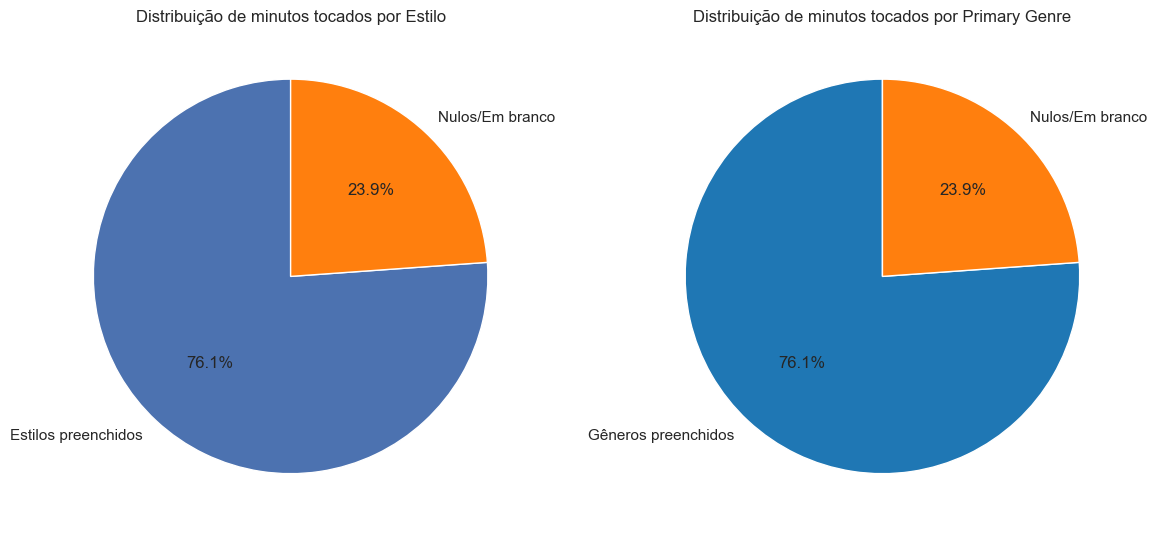

In [40]:

# Criar colunas para diferenciar preenchidos e nulos
df_combined['categoria_estilo'] = df_combined['estilo'].apply(
    lambda x: 'Estilos preenchidos' if pd.notna(x) and x != '' else 'Nulos/Em branco'
)

df_combined['categoria_genero'] = df_combined['primary_style'].apply(
    lambda x: 'Gêneros preenchidos' if pd.notna(x) and x != '' else 'Nulos/Em branco'
)

# Somar minutos por categoria
soma_estilo = df_combined.groupby('categoria_estilo')['minutes_played'].sum()
soma_genero = df_combined.groupby('categoria_genero')['minutes_played'].sum()

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14,7))

# Gráfico de pizza - Estilo
axes[0].pie(
    soma_estilo,
    labels=soma_estilo.index,
    autopct='%1.1f%%',
    colors=['#4c72b0', '#ff7f0e'],
    startangle=90
)
axes[0].set_title('Distribuição de minutos tocados por Estilo')

# Gráfico de pizza - Primary Genre
axes[1].pie(
    soma_genero,
    labels=soma_genero.index,
    autopct='%1.1f%%',
    colors=['#1f77b4', '#ff7f0e'],
    startangle=90
)
axes[1].set_title('Distribuição de minutos tocados por Primary Genre')

plt.show()

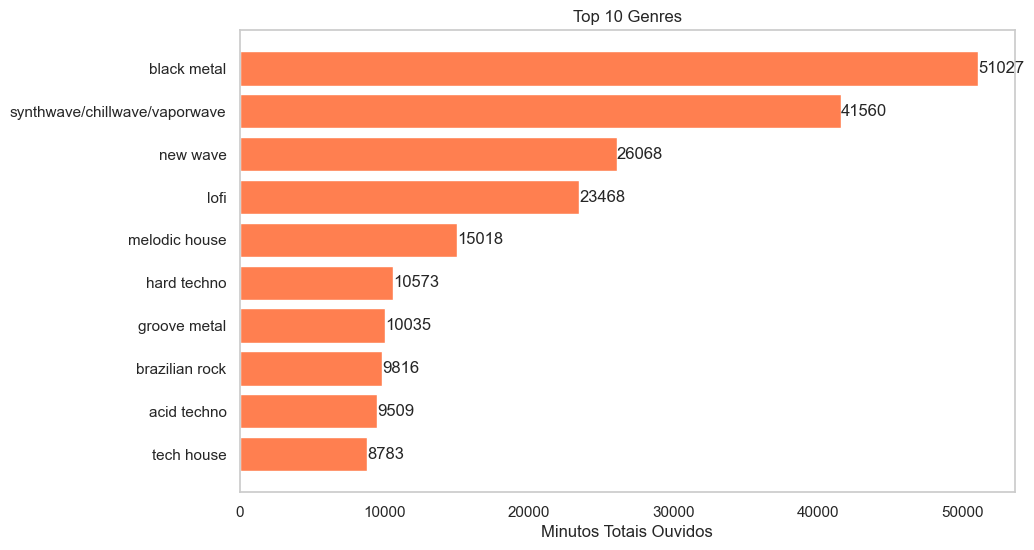

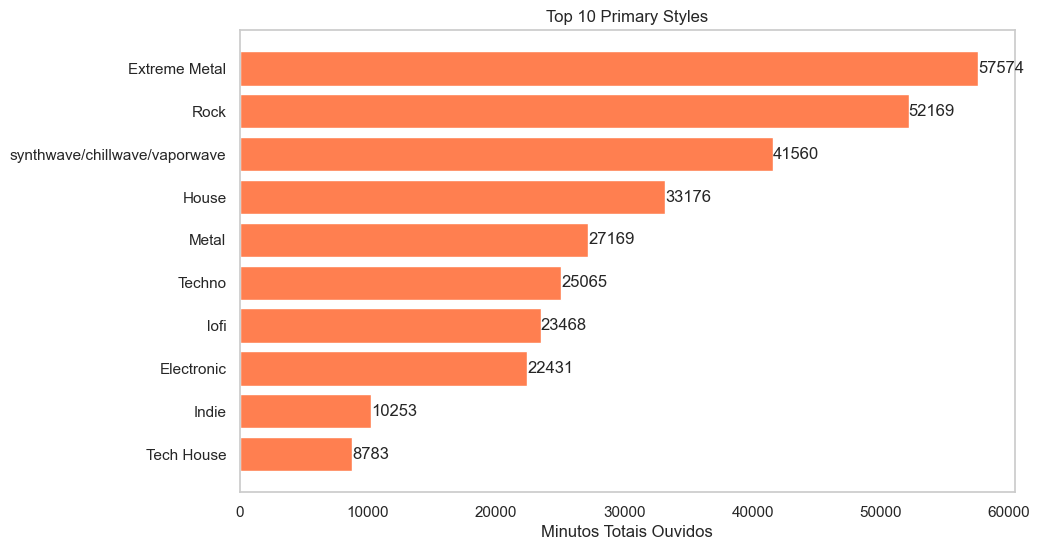

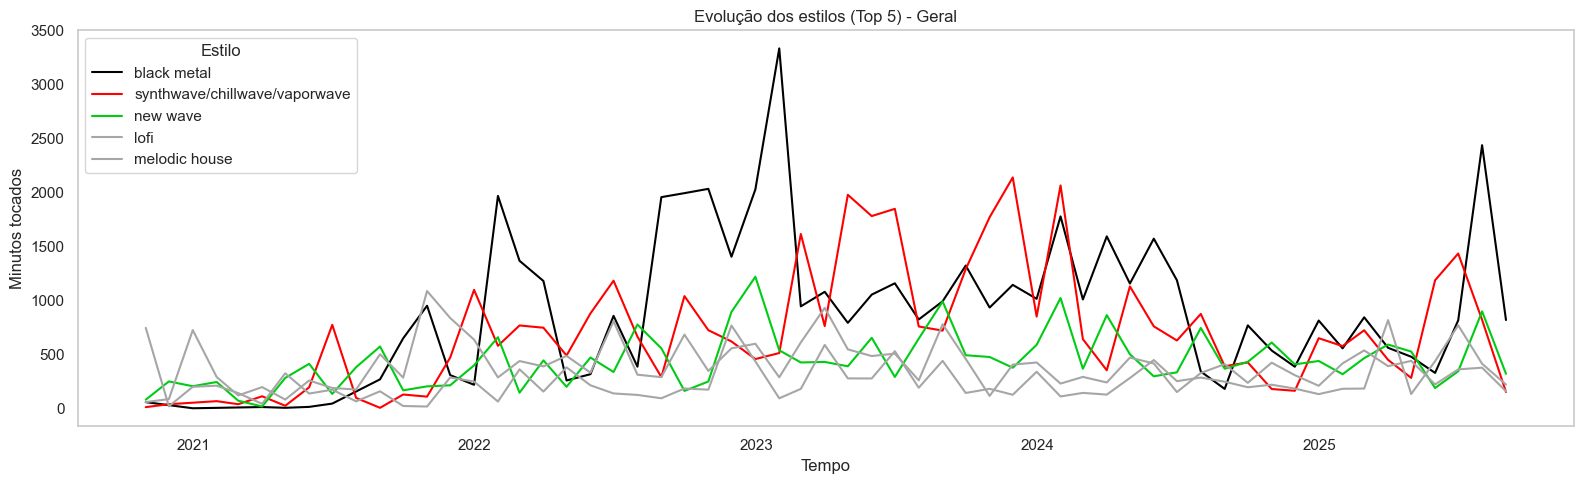

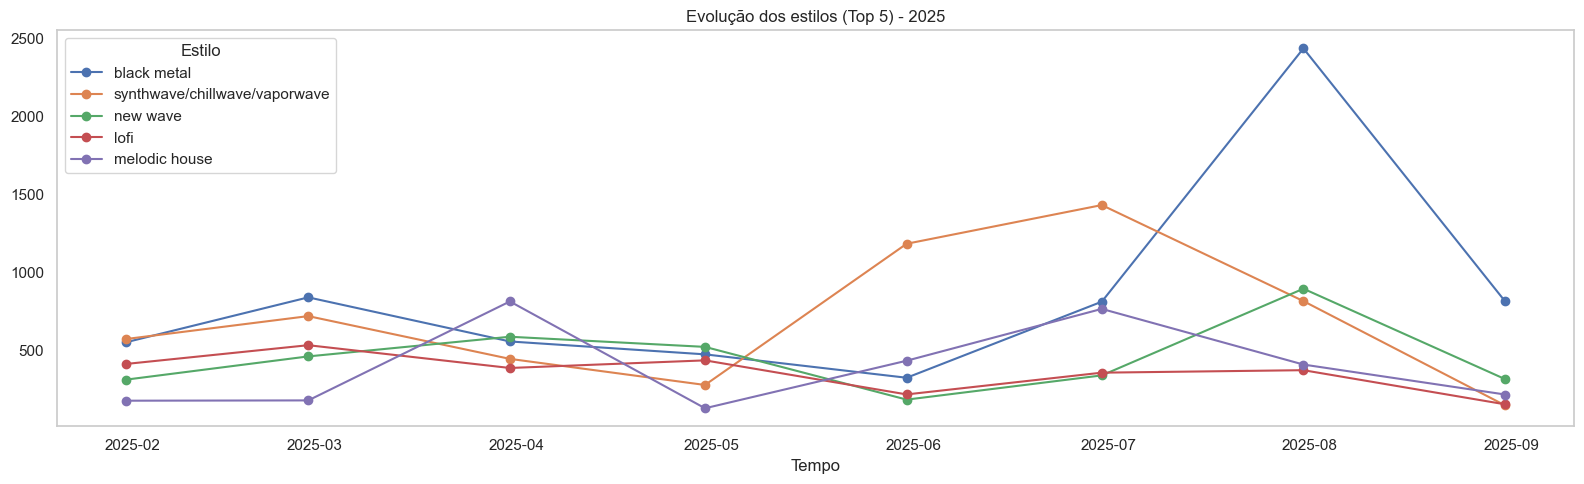

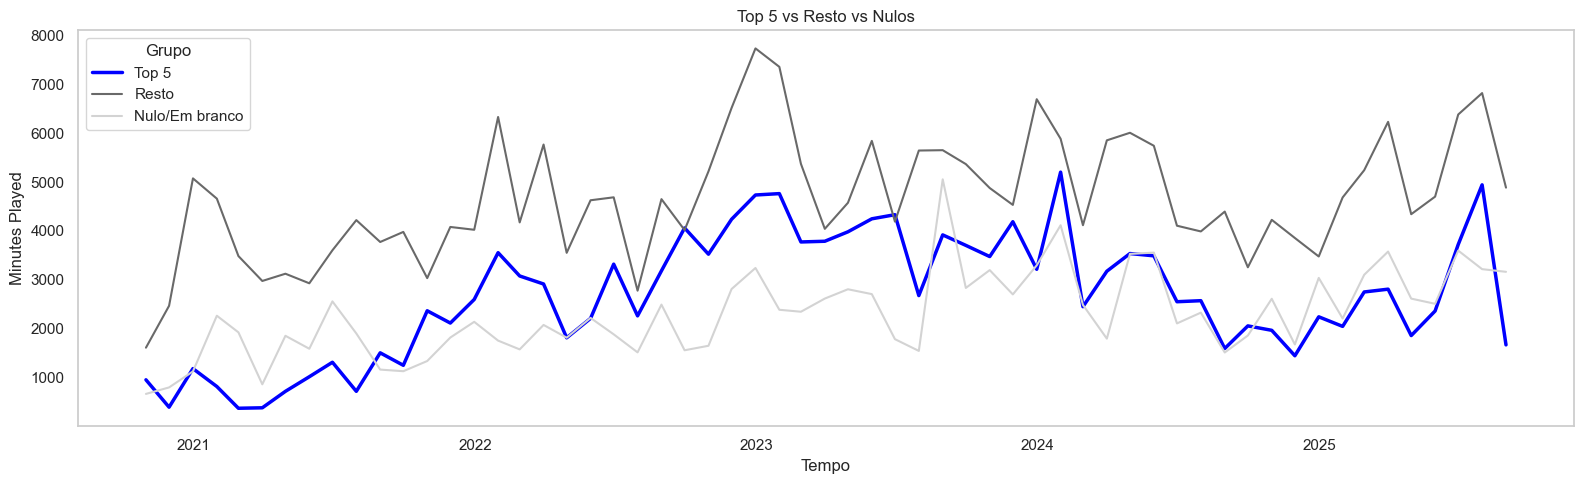

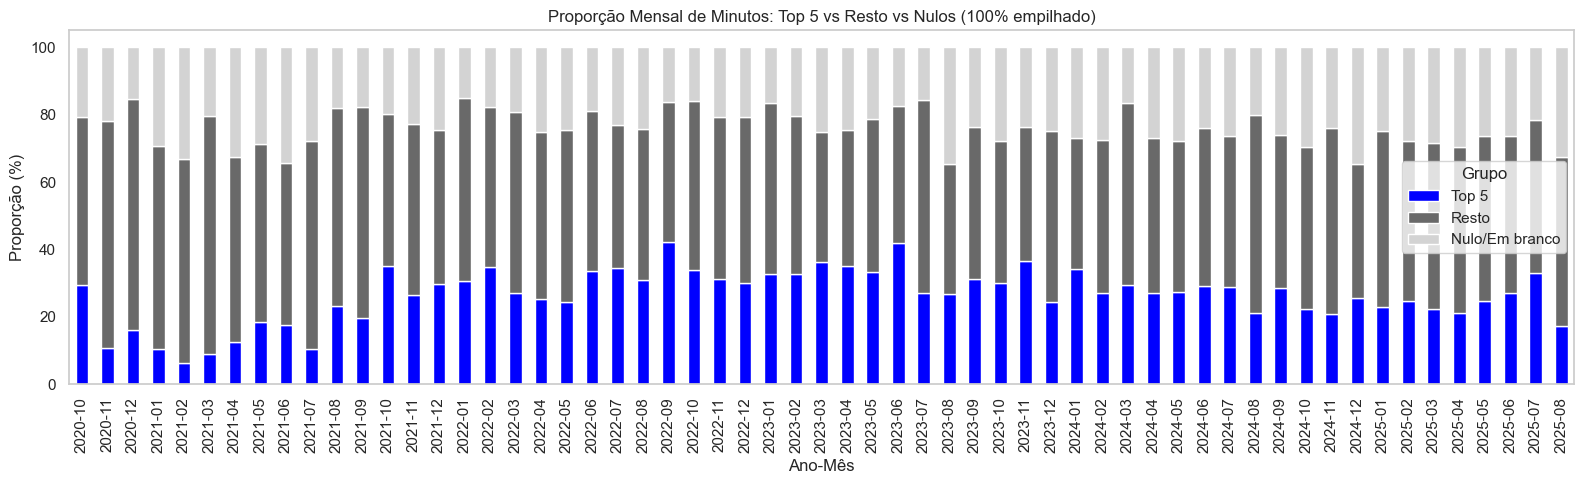

In [41]:
# Análise 24 - Análise por gênero musical e evolução por estilo ao longo do tempo

# ==============================================================
# ANALISE DO TOTAL POR ESTILO
# ==============================================================
# Agrupar por gênero e somar minutos
genre_sum = df_combined.groupby('estilo')['minutes_played'].sum().reset_index()

# Ordenar e pegar top 10
genre_sum = genre_sum.sort_values(by='minutes_played', ascending=False).head(10)

# Criar gráfico horizontal
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(genre_sum['estilo'], genre_sum['minutes_played'], color='coral')
ax.set_title('Top 10 Genres')
ax.set_xlabel('Minutos Totais Ouvidos')
ax.invert_yaxis()  # Para o maior ficar em cima
ax.grid(False)

# Adicionar valores ao lado das barras
for i, v in enumerate(genre_sum['minutes_played']):
    ax.text(v + 5, i, str(int(v)), va='center')

plt.show()


# Agrupar por primary_style e somar minutos
genre_sum2 = df_combined.groupby('primary_style')['minutes_played'].sum().reset_index()

# Ordenar e pegar top 10
genre_sum2 = genre_sum2.sort_values(by='minutes_played', ascending=False).head(10)

# Criar gráfico horizontal
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(genre_sum2['primary_style'], genre_sum2['minutes_played'], color='coral')
ax.set_title('Top 10 Primary Styles')
ax.set_xlabel('Minutos Totais Ouvidos')
ax.invert_yaxis()  # Para o maior ficar em cima
ax.grid(False)

# Adicionar valores ao lado das barras
for i, v in enumerate(genre_sum2['minutes_played']):
    ax.text(v + 5, i, str(int(v)), va='center')

plt.show()



# ==============================================================
# ANALISE AO LONGO DO TEMPO - EVOLUÇÃO (TOP 5 - TOTAL E 2025), TOP 5 X RESTO, COMPOSIÇÃO E PROPORÇÃO DA COMPOSIÇÃO
# ==============================================================
# Agrupar por mês e estilo, somando minutos
estilo_tempo = (
    df_combined
    .groupby([pd.Grouper(key='ts', freq='M'), 'estilo'])['minutes_played']
    .sum()
    .reset_index()
)

# Pegar apenas os top 5 estilos no total
top_estilos = (
    estilo_tempo.groupby('estilo')['minutes_played'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

estilo_tempo_top = estilo_tempo[estilo_tempo['estilo'].isin(top_estilos)]

# Paleta de azuis para os top 5
top5_colors = ["#000000", "#FF0000", "#00CC14FF", "#A6A6A6", "#A6A6A6"]

#   Gráfico 1: Geral  
fig, ax = plt.subplots(figsize=(16,5))
for estilo, color in zip(top_estilos, top5_colors):
    data = estilo_tempo_top[estilo_tempo_top['estilo'] == estilo]
    ax.plot(data['ts'], data['minutes_played'], marker='', label=estilo, color=color)
ax.set_title('Evolução dos estilos (Top 5) - Geral')
ax.set_xlabel('Tempo')
ax.set_ylabel('Minutos tocados')
ax.legend(title='Estilo')
ax.grid(False)
plt.tight_layout()
plt.show()

#   Gráfico 2: Apenas 2025  
fig, ax = plt.subplots(figsize=(16,5))
estilo_2025 = estilo_tempo_top[estilo_tempo_top['ts'].dt.year == 2025]
for estilo in top_estilos:
    data = estilo_2025[estilo_2025['estilo'] == estilo]
    ax.plot(data['ts'], data['minutes_played'], marker='o', label=estilo)
ax.set_title('Evolução dos estilos (Top 5) - 2025')
ax.set_xlabel('Tempo')
ax.legend(title='Estilo')
ax.grid(False)
plt.tight_layout()
plt.show()

#   Gráfico 3: Top 5 vs Resto  
# Preparar coluna para plotagem, substituindo nulos por 'Nulo/Em branco'
df_combined['estilo_plot'] = df_combined['estilo'].fillna('Nulo/Em branco')

# Agrupar por mês e estilo
estilo_tempo_total = (
    df_combined
    .groupby([pd.Grouper(key='ts', freq='M'), 'estilo_plot'])['minutes_played']
    .sum()
    .reset_index()
)

# Categorizar linhas
def categorizar_linha(row):
    if row['estilo_plot'] == 'Nulo/Em branco':
        return 'Nulo/Em branco'
    elif row['estilo_plot'] in top_estilos:
        return 'Top 5'
    else:
        return 'Resto'

estilo_tempo_total['grupo'] = estilo_tempo_total.apply(categorizar_linha, axis=1)

# Agrupar por mês e grupo
grupo_mensal = estilo_tempo_total.groupby(['ts', 'grupo'])['minutes_played'].sum().reset_index()

# Pivot para plot
grupo_pivot = grupo_mensal.pivot(index='ts', columns='grupo', values='minutes_played').fillna(0)

# Plot Gráfico 3: Top 5 embaixo, Resto em cima, Nulo em cima
fig, ax = plt.subplots(figsize=(16,5))

# Ordem para plotar: Top 5 primeiro (embaixo), depois Resto, depois Nulo
plot_order = [
    ('Top 5', 'blue', 2.5),       # grosso
    ('Resto', 'dimgray', 1.5),    # médio
    ('Nulo/Em branco', 'lightgray', 1.5)  # fino
]

for grupo, cor, lw in plot_order:
    if grupo in grupo_pivot.columns:
        ax.plot(grupo_pivot.index, grupo_pivot[grupo], marker='', label=grupo, color=cor, linewidth=lw)

ax.set_title('Top 5 vs Resto vs Nulos')
ax.set_xlabel('Tempo')
ax.set_ylabel('Minutes Played')
ax.legend(title='Grupo')
ax.grid(False)
plt.tight_layout()
plt.show()

#   Gráfico 4: Barras 100% empilhadas Top 5 vs Resto  
# Agrupar por mês e grupo
monthly_group = grupo_pivot.copy()

# Calcular proporções percentuais
monthly_group_percent = monthly_group.div(monthly_group.sum(axis=1), axis=0) * 100

# Converter índice para strings "YYYY-MM"
monthly_group_percent.index = monthly_group_percent.index.to_period('M').strftime('%Y-%m')

# Plotar gráfico empilhado com mesma ordem e cores do gráfico 3
fig, ax = plt.subplots(figsize=(16,5))

# Definir cores na mesma ordem: Top 5, Resto, Nulo
cores = ['blue', 'dimgray', 'lightgray']
ordem_colunas = ['Top 5', 'Resto', 'Nulo/Em branco']

# Garantir que todas as colunas existam
for col in ordem_colunas:
    if col not in monthly_group_percent.columns:
        monthly_group_percent[col] = 0

# Reordenar colunas para plot
monthly_group_percent = monthly_group_percent[ordem_colunas]

# Plotar empilhado
monthly_group_percent.plot(kind='bar', stacked=True, ax=ax, color=cores)

ax.set_title('Proporção Mensal de Minutos: Top 5 vs Resto vs Nulos (100% empilhado)')
ax.set_xlabel('Ano-Mês')
ax.set_ylabel('Proporção (%)')
ax.legend(title='Grupo')
ax.grid(False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


